In [1]:
import collections
import pickle as pk
import re
import time

from matplotlib import pyplot as plt
import nasdaqdatalink
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Analysis is for Alameda County, CA

### Weather Data

This data was collected from https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/county/time-series/CA-001/

In [2]:
avg_temp = pd.read_csv("avgtemp_alameda_ca_1895-2022.csv", skiprows=4)
max_temp = pd.read_csv("maxtemp_alameda_ca_1895-2022.csv", skiprows=4)
min_temp = pd.read_csv("mintemp_alameda_ca_1895-2022.csv", skiprows=4)
precipitation = pd.read_csv("precipitation_alameda_ca_1895-2022.csv", skiprows=4)
heatingdegreedays = pd.read_csv("heatingdegreedays_alameda_ca_1895-2022.csv", skiprows=4)
coolingdegreedays = pd.read_csv("coolingdegreedays_alameda_ca_1895-2022.csv", skiprows=4)

In [3]:
print(avg_temp.shape, max_temp.shape, min_temp.shape, precipitation.shape,
      heatingdegreedays.shape, coolingdegreedays.shape)

(127, 3) (127, 3) (127, 3) (127, 3) (127, 3) (127, 3)


In [4]:
print(avg_temp.isnull().sum(), max_temp.isnull().sum(), min_temp.isnull().sum(),
      precipitation.isnull().sum(), heatingdegreedays.isnull().sum(),
      coolingdegreedays.isnull().sum())

Date       0
Value      0
Anomaly    0
dtype: int64 Date       0
Value      0
Anomaly    0
dtype: int64 Date       0
Value      0
Anomaly    0
dtype: int64 Date       0
Value      0
Anomaly    0
dtype: int64 Date       0
Value      0
Anomaly    0
dtype: int64 Date       0
Value      0
Anomaly    0
dtype: int64


The first 4 digits denote the year in date. Last two digits (12) denote that the data is aggregated annually

In [5]:
avg_temp.head()

Date  Value  Anomaly
0  189512   56.6     -1.3
1  189612   57.5     -0.4
2  189712   56.6     -1.3
3  189812   57.3     -0.6
4  189912   57.3     -0.6

In [6]:
avg_temp.tail()

Date  Value  Anomaly
122  201712   60.5      2.6
123  201812   59.8      1.9
124  201912   59.7      1.8
125  202012   61.7      3.8
126  202112   60.0      2.1

### Residential electricity consumption data 

The data was fetched from https://ecdms.energy.ca.gov/elecbycounty.aspx

In [7]:
# pip3 install openpyxl
electricity_consumption = pd.read_excel("ElectricityByCounty_alameda_ca.xlsx")

In [8]:
electricity_consumption

County       Sector        2021         2020         2019         2018  \
0  ALAMEDA  Residential  3308.25946  3308.467553  3015.393947  2948.368675   

          2017         2016         2015         2014  ...         1998  \
0  2995.051965  2920.921179  2897.493974  2894.253363  ...  2791.331173   

          1997         1996         1995         1994         1993  \
0  2674.834394  2615.308775  2548.457958  2774.566317  2529.229286   

          1992        1991         1990  Total Usage  
0  2465.000074  2515.20997  2498.265626  92070.19114  

[1 rows x 35 columns]

In [9]:
electricity_consumption = electricity_consumption.transpose()

In [10]:
electricity_consumption

0
County           ALAMEDA
Sector       Residential
2021          3308.25946
2020         3308.467553
2019         3015.393947
2018         2948.368675
2017         2995.051965
2016         2920.921179
2015         2897.493974
2014         2894.253363
2013         2986.226437
2012         2999.683662
2011         3024.848218
2010         3021.677436
2009         3016.750714
2008         2996.423893
2007         2971.909026
2006         3118.292069
2005         3025.275108
2004         2897.838896
2003         2937.121764
2002         2811.630947
2001         2745.213966
2000          2926.11798
1999         2890.767335
1998         2791.331173
1997         2674.834394
1996         2615.308775
1995         2548.457958
1994         2774.566317
1993         2529.229286
1992         2465.000074
1991          2515.20997
1990         2498.265626
Total Usage  92070.19114

In [11]:
electricity_consumption.drop(['County', 'Sector', 'Total Usage'], inplace=True)

In [12]:
electricity_consumption

0
2021   3308.25946
2020  3308.467553
2019  3015.393947
2018  2948.368675
2017  2995.051965
2016  2920.921179
2015  2897.493974
2014  2894.253363
2013  2986.226437
2012  2999.683662
2011  3024.848218
2010  3021.677436
2009  3016.750714
2008  2996.423893
2007  2971.909026
2006  3118.292069
2005  3025.275108
2004  2897.838896
2003  2937.121764
2002  2811.630947
2001  2745.213966
2000   2926.11798
1999  2890.767335
1998  2791.331173
1997  2674.834394
1996  2615.308775
1995  2548.457958
1994  2774.566317
1993  2529.229286
1992  2465.000074
1991   2515.20997
1990  2498.265626

In [13]:
type(electricity_consumption)

pandas.core.frame.DataFrame

In [14]:
electricity_consumption.shape

(32, 1)

In [15]:
electricity_consumption[0][::-1]

1990    2498.265626
1991     2515.20997
1992    2465.000074
1993    2529.229286
1994    2774.566317
1995    2548.457958
1996    2615.308775
1997    2674.834394
1998    2791.331173
1999    2890.767335
2000     2926.11798
2001    2745.213966
2002    2811.630947
2003    2937.121764
2004    2897.838896
2005    3025.275108
2006    3118.292069
2007    2971.909026
2008    2996.423893
2009    3016.750714
2010    3021.677436
2011    3024.848218
2012    2999.683662
2013    2986.226437
2014    2894.253363
2015    2897.493974
2016    2920.921179
2017    2995.051965
2018    2948.368675
2019    3015.393947
2020    3308.467553
2021     3308.25946
Name: 0, dtype: object

In [16]:
electricity_consumption = electricity_consumption[0][::-1]

In [17]:
electricity_consumption = pd.to_numeric(electricity_consumption)

In [18]:
electricity_consumption

1990    2498.265626
1991    2515.209970
1992    2465.000074
1993    2529.229286
1994    2774.566317
1995    2548.457958
1996    2615.308775
1997    2674.834394
1998    2791.331173
1999    2890.767335
2000    2926.117980
2001    2745.213966
2002    2811.630947
2003    2937.121764
2004    2897.838896
2005    3025.275108
2006    3118.292069
2007    2971.909026
2008    2996.423893
2009    3016.750714
2010    3021.677436
2011    3024.848218
2012    2999.683662
2013    2986.226437
2014    2894.253363
2015    2897.493974
2016    2920.921179
2017    2995.051965
2018    2948.368675
2019    3015.393947
2020    3308.467553
2021    3308.259460
Name: 0, dtype: float64

### Reservoir levels

Reservoir levels (CA only)
- https://cdec.water.ca.gov/reportapp/javareports?name=RES
- Daily (at midnight) reservoir levels are available.
- We do not know which county is served by which reservoir. Many reservoirs lie/serve in multiple counties.
- Monthly data available for each water year.
- Tried fetching data as back as 1973 because we do not have older electricity data.
https://cdec.water.ca.gov/dynamicapp/QueryWY?Stations=CLE&SensorNums=15&End=2022-12-01&span=50
- Reservoir info: https://cdec.water.ca.gov/reportapp/javareports?name=ResInfo

In [19]:
reservoir_metadata = pd.read_csv('Reservoir Information Sorted By Dam Name.csv')

In [20]:
reservoir_metadata

ID           DAM                    LAKE            STREAM  \
0    APN        Alpine             Alpine Lake   Lagunitas Creek   
1    ANT      Antelope                Antelope      Indian Creek   
2    AST      Austrian           Lake Austrian   Los Gatos Creek   
3    BRT       Barrett            Barrett Lake  Cottonwood Creek   
4    BAR          Bear                     NaN        Bear Creek   
..   ...           ...                     ...               ...   
222  VLP    Villa Park    Villa Park Reservoir    Santiago Creek   
223  WRS  Warm Springs  Warm Springs Reservoir     Russian River   
224  WHR    Whale Rock         Whale Rock Lake         Old Creek   
225  WHI   Whiskeytown        Whiskeytown Lake       Clear Creek   
226  WSN        Wishon             Lake Wishon       Helms Creek   

     CAPACITY (AF)  
0           8892.0  
1          22566.0  
2           6200.0  
3          34805.0  
4           7700.0  
..             ...  
222        15600.0  
223       381000.0  
224        38967.0  
225       241100.0  
226       128300.0  

[227 rows x 5 columns]

Collect information about the location of each reservoir. The following code specifically fetches the data for California.

In [21]:
reservoir_county_dict = {}

In [22]:
# for i in reservoir_metadata['ID']:
#     done = False
#     if i not in reservoir_county_dict and i != 'MCR':
#         while not done:
#             try:
#                 time.sleep(5)
#                 r = requests.get('https://cdec.water.ca.gov/dynamicapp/staMeta?station_id={}'.format(i))
#             except:
#                 continue
#             re_match = re.search("County</b></td><td>([\w+\s*]+)</td></tr>", r.text)
#             r.close()
#             reservoir_county_dict[i] = re_match.groups()[0]
#             print(i, re_match.groups()[0])
#             done = True

In [23]:
# with open('reservoir_county_dict.pk', 'wb') as f:
#     pk.dump(reservoir_county_dict, f)

In [24]:
with open('reservoir_county_dict.pk', 'rb') as f:
    reservoir_county_dict =  pk.load(f)

In [25]:
reservoir_county_dict

{'APN': 'MARIN',
 'ANT': 'PLUMAS',
 'AST': 'SANTA CLARA',
 'BRT': 'SAN DIEGO',
 'BAR': 'MARIPOSA',
 'BRV': 'SAN BERNARDINO',
 'BRD': 'TUOLUMNE',
 'BTH': 'ALAMEDA',
 'BLB': 'TEHAMA',
 'BOC': 'NEVADA',
 'BMP': 'MARIN',
 'BQC': 'LOS ANGELES',
 'BWN': 'NEVADA',
 'BWS': 'NEVADA',
 'BDP': 'MONO',
 'BIO': 'CONTRA COSTA',
 'BHC': 'EL DORADO',
 'BUC': 'MADERA',
 'BIL': 'EL DORADO',
 'BCL': 'PLUMAS',
 'BTV': 'PLUMAS',
 'CCH': 'SANTA BARBARA',
 'CVE': 'ALAMEDA',
 'CRO': 'SANTA CLARA',
 'CMN': 'SAN JOAQUIN',
 'CMI': 'EL DORADO',
 'CFW': 'YUBA',
 'ALM': 'PLUMAS',
 'CPL': 'ALPINE',
 'CSI': 'VENTURA',
 'CAS': 'LOS ANGELES',
 'SLW': 'SAN BERNARDINO',
 'CHB': 'ALAMEDA',
 'CHV': 'TUOLUMNE',
 'JNN': 'SAN DIEGO',
 'CLK': 'MODOC',
 'CLA': 'LAKE',
 'CLC': 'CONTRA COSTA',
 'CGS': 'LOS ANGELES',
 'CMB': 'NEVADA',
 'CTG': 'FRESNO',
 'CYC': 'SANTA CLARA',
 'COY': 'MENDOCINO',
 'CNV': 'MADERA',
 'CUY': 'SAN DIEGO',
 'MHV': 'State of Nevada',
 'DLV': 'ALAMEDA',
 'DMV': 'RIVERSIDE',
 'DNP': 'TUOLUMNE',
 'DON': 'TU

In [26]:
alameda_reservoirs = []
for k, v in reservoir_county_dict.items():
    if v == 'ALAMEDA':
        alameda_reservoirs.append(k)

In [27]:
alameda_reservoirs

['BTH', 'CVE', 'CHB', 'DLV', 'SAT', 'USL']

Get data for each reservoir manually

In [28]:
BTH_reservoir_data = pd.read_csv('BETHANY FOREBAY (BTH).csv')
CVE_reservoir_data = pd.read_csv('CALAVERAS (CVE).csv')
CHB_reservoir_data = pd.read_csv('CHABOT (CHB).csv')
DLV_reservoir_data = pd.read_csv('DEL VALLE (DLV).csv')
SAT_reservoir_data = pd.read_csv('SAN ANTONIO RESERVOIR (SAT).csv')
USL_reservoir_data = pd.read_csv('U SAN LEANDRO (USL).csv')

In [29]:
BTH_reservoir_data.set_index('Water Year(WY)', inplace=True)
CVE_reservoir_data.set_index('Water Year(WY)', inplace=True)
CHB_reservoir_data.set_index('Water Year(WY)', inplace=True)
DLV_reservoir_data.set_index('Water Year(WY)', inplace=True)
SAT_reservoir_data.set_index('Water Year(WY)', inplace=True)
USL_reservoir_data.set_index('Water Year(WY)', inplace=True)

In [30]:
BTH_reservoir_data

Oct    Nov    Dec    Jan    Feb    Mar    Apr    May    Jun  \
Water Year(WY)                                                                  
1974              NaN    NaN  4,735  4,700  4,764  4,751  4,614  4,682  4,682   
1975            4,804  4,545  4,751  4,718  4,718  4,700  4,682  4,561  4,209   
1976            4,700  4,718  4,631  4,735  4,649  4,858  4,545  4,375  4,682   
1977            4,631  4,598  4,511  4,682  4,682  4,561  4,012  4,735  4,494   
1978            4,529  4,666  4,598  4,718  4,631  4,631  4,718  4,598    ---   
1979            4,718  4,614  4,563  4,597  4,416  4,666  4,494  4,771  4,753   
1980            4,528  4,824  4,597  4,426  4,511  3,997  3,981  4,618  4,614   
1981            4,666  4,466  4,753  4,242  4,771  4,563  4,983  4,648  4,426   
1982            4,701  4,876  4,701  4,750  4,800  4,876  4,632  4,947  4,876   
1983            4,649  4,855  4,649  4,666  4,666  4,409  4,580  4,511  4,649   
1984            4,736  4,701  4,753  4,580  4,894  4,704  4,824  4,545  4,136   
1985            4,511  4,649  4,771  4,718  4,701  4,649  4,753  4,774  4,818   
1986            4,759  4,771  4,759  4,666  4,824  4,377  4,678  4,217  4,759   
1987            4,825  4,666  4,540  4,736  4,752  4,813  4,776  4,656  4,766   
1988            4,797  4,623  4,687  4,736  4,764  4,540  4,621  4,753  4,651   
1989            4,769  4,725  4,736  4,813  4,704  4,689  4,963  4,687  4,790   
1990            4,621  4,831  4,787  4,802  4,792  4,743  4,440  4,258  4,494   
1991            4,869  4,545  4,818  4,868  4,930  4,801  4,092  4,153  4,912   
1992            4,727  4,128  4,671  4,632  4,928  4,846  4,684  5,069  4,806   
1993            4,969  5,008  4,859  4,931  4,727  4,841  4,590  4,869  4,684   
1994            4,910  4,613  4,736  4,771  4,753  4,275  5,006  4,962  5,062   
1995            4,857  4,862  4,839  4,841  4,736  4,484  4,374  4,792  4,806   
1996            4,808  4,335  4,914  5,063  4,857  4,614  4,477  4,852  4,953   
1997            4,887  4,820  4,607  4,815  4,887  4,731  4,845  4,308  4,928   
1998            4,658  4,808  4,576  4,725  4,739  4,455  4,457  4,731  4,834   
1999            4,769  4,855  4,760  4,479  4,729  4,938  4,673  4,652  4,917   
2000            4,588  4,588  4,799  4,647  4,609  4,766  4,836  4,755  4,573   
2001            4,492  4,561  4,685  4,710    ---    ---    ---    ---    ---   
2002              ---    ---    ---    ---    ---    ---    ---    ---    ---   
2003              ---    ---    ---    ---    ---    ---    ---    ---    ---   
2004              ---    ---    ---    ---    ---    ---    ---    ---    ---   

                  Jul    Aug    Sep  
Water Year(WY)                       
1974            4,718  4,666  4,631  
1975            4,357  4,682  4,764  
1976            4,718  4,786  4,751  
1977            4,520  4,550  4,581  
1978            4,751  4,581  4,930  
1979            4,736  4,718  4,649  
1980            4,494  4,632  4,597  
1981            4,614  4,701  4,494  
1982            4,649  4,597  4,545  
1983            4,718  4,443  4,718  
1984            4,829  4,850  4,771  
1985            4,788  4,752  4,813  
1986            4,694  4,774  4,725  
1987            4,746  4,815  4,748  
1988            4,736  4,806  4,607  
1989            4,846  4,979  4,575  
1990            4,841  4,983  4,876  
1991            4,367  4,787  4,969  
1992            4,532  4,947  4,736  
1993            4,696  4,841  4,818  
1994            5,028  4,710  5,008  
1995            4,972  4,738  4,875  
1996            4,894  4,894  4,838  
1997            4,809  4,701  4,824  
1998            4,741  4,760  4,804  
1999            4,866  4,750  4,638  
2000            4,597  4,771  4,727  
2001              ---    ---    ---  
2002              ---    ---    ---  
2003              ---    ---    ---  
2004              ---    ---    ---

It seems that BETHANY FOREBAY (BTH) reservoir was not acitve post 2000. We need to convert Water Year data to actual annual data. A water year in the USA starts from preceeding Oct. Hence move data for Oct to Dec up by one record.

In [31]:
def convert_from_water_year(df):
    df.Oct = df.Oct.shift(-1)
    df.Nov = df.Nov.shift(-1)
    df.Dec = df.Dec.shift(-1)
    df.drop(2023, inplace=True)

In [32]:
# convert_from_water_year(BTH_reservoir_data)
convert_from_water_year(CVE_reservoir_data)
convert_from_water_year(CHB_reservoir_data)
convert_from_water_year(DLV_reservoir_data)
convert_from_water_year(SAT_reservoir_data)
convert_from_water_year(USL_reservoir_data)
BTH_reservoir_data = BTH_reservoir_data[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
CVE_reservoir_data = CVE_reservoir_data[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
CHB_reservoir_data = CHB_reservoir_data[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
DLV_reservoir_data = DLV_reservoir_data[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
SAT_reservoir_data = SAT_reservoir_data[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
USL_reservoir_data = USL_reservoir_data[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

In [33]:
USL_reservoir_data

Jan     Feb     Mar     Apr     May     Jun     Jul  \
Water Year(WY)                                                           
1974            21,310  22,630  24,190  22,950  22,500  22,510  22,280   
1975            21,170  22,450  22,630  22,830  21,190  20,390  19,920   
1976            16,790  18,320  17,460  17,360  17,390  17,750  18,010   
1977            17,760  18,790  18,710  18,290  18,570  18,310  18,980   
1978            33,530  37,380  41,710  41,660  40,440  39,140  37,710   
1979            34,000  36,950  38,100  39,720  39,530  37,390  35,570   
1980            37,100  42,100  40,600  39,030  37,500  35,540  33,500   
1981            27,410  30,110  34,300  34,630  33,600  30,770  27,560   
1982            41,500  41,390  43,180  40,820  38,430  36,510  34,110   
1983            41,350  42,180  41,700  40,120  38,590  35,440  31,700   
1984            32,880  34,410  37,010  38,690  36,830  34,780  29,120   
1985            30,020  32,980  36,110  37,310  36,280  34,290  31,300   
1986            27,140  41,110  39,500  38,050  35,370  32,210  29,560   
1987            28,810  33,010  35,380  33,880  31,260  28,592  26,199   
1988            27,234  29,793  32,580  33,995  35,353  34,215  32,094   
1989            29,132  32,043  36,496  35,387  34,021  32,362  30,162   
1990            28,844  29,441  32,419  34,389  34,048  32,955  31,268   
1991            27,341  29,262  34,383  35,932  35,339  34,188  32,619   
1992            28,600  30,800  31,480  34,320  32,860  31,260  29,460   
1993            34,880  38,030  38,520  38,010  26,990  34,700  32,380   
1994            28,280  31,060  32,630  32,110  31,740  29,520  27,780   
1995            32,970  33,470  39,800  38,840  38,190  35,320  32,390   
1996            30,200  36,730  38,740  38,560  37,690  36,220  33,730   
1997            39,490  36,370  35,860  41,440  34,760  36,520  36,520   
1998            38,500  41,440  38,360  38,630  38,310  36,690  36,360   
1999            32,650  38,610  38,560  41,440  37,950  36,630  35,030   
2000            31,610  33,310  38,040  37,420  36,850  35,320  33,680   
2001            28,470  32,230  34,540  37,190  35,410  33,060  30,440   
2002            28,380  27,910  31,170  34,340  33,000  30,720  28,280   
2003            30,580  31,260  31,770  34,270  33,716  31,460  29,080   
2004            26,080  33,900  35,660  34,850  32,015  29,120  26,185   
2005            30,590  30,130  35,300  37,476  36,367  35,010  32,920   
2006            32,660  33,160  38,315  37,730  37,300  35,760  33,240   
2007            23,200  26,250  28,300  31,760  30,220  28,475  26,710   
2008            25,980  28,945  29,420  28,390  26,870  29,670  29,510   
2009            25,980  29,830  31,930  32,090  31,800  30,540  28,580   
2010            28,210  29,920  32,030  34,140  34,540  34,390  32,970   
2011            30,650  34,490  37,600  35,510  36,060  36,110  34,640   
2012            29,330  29,640  35,140  37,390  36,400  34,930  32,360   
2013            29,910  30,200  29,680  29,700  29,530  29,430  29,100   
2014            28,600  29,940  29,410  28,530  27,970  30,940  30,720   
2015            23,980  23,410  22,570  23,200  25,480  27,390  30,120   
2016            29,010  27,910  35,350  35,850  35,740  35,440  35,070   
2017            39,000  39,300  35,510  33,070  28,660  26,220  25,070   
2018            27,610  27,730  30,240  32,340  32,330  32,070  31,770   
2019            28,350  35,710  36,570  36,660  37,370  37,220  36,920   
2020            32,370  32,390  32,730  33,020  32,990  32,680  32,320   
2021            26,120  25,010  26,240  28,360  26,760  25,450  24,210   
2022            33,790  33,590  36,300  34,080  30,490  28,620  26,480   

                   Aug     Sep     Oct     Nov     Dec  
Water Year(WY)                                          
1974            21,540  20,550  17,730  18,220  19,480  
1975            20,320  20,280  19,760  18,850  17,920  
1976            

In [34]:
BTH_reservoir_data.drop([2001, 2002, 2003, 2004], inplace=True)

/var/folders/x3/2hd_qhx56tq45b4y4z4nl7br0000gr/T/ipykernel_54297/3595556214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTH_reservoir_data.drop([2001, 2002, 2003, 2004], inplace=True)


In [35]:
BTH_reservoir_data

Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep  \
Water Year(WY)                                                                  
1974            4,700  4,764  4,751  4,614  4,682  4,682  4,718  4,666  4,631   
1975            4,718  4,718  4,700  4,682  4,561  4,209  4,357  4,682  4,764   
1976            4,735  4,649  4,858  4,545  4,375  4,682  4,718  4,786  4,751   
1977            4,682  4,682  4,561  4,012  4,735  4,494  4,520  4,550  4,581   
1978            4,718  4,631  4,631  4,718  4,598    ---  4,751  4,581  4,930   
1979            4,597  4,416  4,666  4,494  4,771  4,753  4,736  4,718  4,649   
1980            4,426  4,511  3,997  3,981  4,618  4,614  4,494  4,632  4,597   
1981            4,242  4,771  4,563  4,983  4,648  4,426  4,614  4,701  4,494   
1982            4,750  4,800  4,876  4,632  4,947  4,876  4,649  4,597  4,545   
1983            4,666  4,666  4,409  4,580  4,511  4,649  4,718  4,443  4,718   
1984            4,580  4,894  4,704  4,824  4,545  4,136  4,829  4,850  4,771   
1985            4,718  4,701  4,649  4,753  4,774  4,818  4,788  4,752  4,813   
1986            4,666  4,824  4,377  4,678  4,217  4,759  4,694  4,774  4,725   
1987            4,736  4,752  4,813  4,776  4,656  4,766  4,746  4,815  4,748   
1988            4,736  4,764  4,540  4,621  4,753  4,651  4,736  4,806  4,607   
1989            4,813  4,704  4,689  4,963  4,687  4,790  4,846  4,979  4,575   
1990            4,802  4,792  4,743  4,440  4,258  4,494  4,841  4,983  4,876   
1991            4,868  4,930  4,801  4,092  4,153  4,912  4,367  4,787  4,969   
1992            4,632  4,928  4,846  4,684  5,069  4,806  4,532  4,947  4,736   
1993            4,931  4,727  4,841  4,590  4,869  4,684  4,696  4,841  4,818   
1994            4,771  4,753  4,275  5,006  4,962  5,062  5,028  4,710  5,008   
1995            4,841  4,736  4,484  4,374  4,792  4,806  4,972  4,738  4,875   
1996            5,063  4,857  4,614  4,477  4,852  4,953  4,894  4,894  4,838   
1997            4,815  4,887  4,731  4,845  4,308  4,928  4,809  4,701  4,824   
1998            4,725  4,739  4,455  4,457  4,731  4,834  4,741  4,760  4,804   
1999            4,479  4,729  4,938  4,673  4,652  4,917  4,866  4,750  4,638   
2000            4,647  4,609  4,766  4,836  4,755  4,573  4,597  4,771  4,727   

                  Oct    Nov    Dec  
Water Year(WY)                       
1974              NaN    NaN  4,735  
1975            4,804  4,545  4,751  
1976            4,700  4,718  4,631  
1977            4,631  4,598  4,511  
1978            4,529  4,666  4,598  
1979            4,718  4,614  4,563  
1980            4,528  4,824  4,597  
1981            4,666  4,466  4,753  
1982            4,701  4,876  4,701  
1983            4,649  4,855  4,649  
1984            4,736  4,701  4,753  
1985            4,511  4,649  4,771  
1986            4,759  4,771  4,759  
1987            4,825  4,666  4,540  
1988            4,797  4,623  4,687  
1989            4,769  4,725  4,736  
1990            4,621  4,831  4,787  
1991            4,869  4,545  4,818  
1992            4,727  4,128  4,671  
1993            4,969  5,008  4,859  
1994            4,910  4,613  4,736  
1995            4,857  4,862  4,839  
1996            4,808  4,335  4,914  
1997            4,887  4,820  4,607  
1998            4,658  4,808  4,576  
1999            4,769  4,855  4,760  
2000            4,588  4,588  4,799

Replace missing data '---' by monthly average.

In [36]:
def clean_reservoir_data(df):
    for i in df:
        df[i] = df[i].str.replace(',', '')
        df[i] = pd.to_numeric(df[i], errors='coerce')
    df.fillna(df.mean().round(0), inplace=True)

In [37]:
clean_reservoir_data(BTH_reservoir_data)
clean_reservoir_data(CVE_reservoir_data)
clean_reservoir_data(CHB_reservoir_data)
clean_reservoir_data(DLV_reservoir_data)
clean_reservoir_data(SAT_reservoir_data)
clean_reservoir_data(USL_reservoir_data)

/var/folders/x3/2hd_qhx56tq45b4y4z4nl7br0000gr/T/ipykernel_54297/1388946777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].str.replace(',', '')
/var/folders/x3/2hd_qhx56tq45b4y4z4nl7br0000gr/T/ipykernel_54297/1388946777.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = pd.to_numeric(df[i], errors='coerce')
/var/folders/x3/2hd_qhx56tq45b4y4z4nl7br0000gr/T/ipykernel_54297/1388946777.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [38]:
BTH_reservoir_data

Jan   Feb   Mar   Apr   May     Jun   Jul   Aug   Sep  \
Water Year(WY)                                                           
1974            4700  4764  4751  4614  4682  4682.0  4718  4666  4631   
1975            4718  4718  4700  4682  4561  4209.0  4357  4682  4764   
1976            4735  4649  4858  4545  4375  4682.0  4718  4786  4751   
1977            4682  4682  4561  4012  4735  4494.0  4520  4550  4581   
1978            4718  4631  4631  4718  4598  4703.0  4751  4581  4930   
1979            4597  4416  4666  4494  4771  4753.0  4736  4718  4649   
1980            4426  4511  3997  3981  4618  4614.0  4494  4632  4597   
1981            4242  4771  4563  4983  4648  4426.0  4614  4701  4494   
1982            4750  4800  4876  4632  4947  4876.0  4649  4597  4545   
1983            4666  4666  4409  4580  4511  4649.0  4718  4443  4718   
1984            4580  4894  4704  4824  4545  4136.0  4829  4850  4771   
1985            4718  4701  4649  4753  4774  4818.0  4788  4752  4813   
1986            4666  4824  4377  4678  4217  4759.0  4694  4774  4725   
1987            4736  4752  4813  4776  4656  4766.0  4746  4815  4748   
1988            4736  4764  4540  4621  4753  4651.0  4736  4806  4607   
1989            4813  4704  4689  4963  4687  4790.0  4846  4979  4575   
1990            4802  4792  4743  4440  4258  4494.0  4841  4983  4876   
1991            4868  4930  4801  4092  4153  4912.0  4367  4787  4969   
1992            4632  4928  4846  4684  5069  4806.0  4532  4947  4736   
1993            4931  4727  4841  4590  4869  4684.0  4696  4841  4818   
1994            4771  4753  4275  5006  4962  5062.0  5028  4710  5008   
1995            4841  4736  4484  4374  4792  4806.0  4972  4738  4875   
1996            5063  4857  4614  4477  4852  4953.0  4894  4894  4838   
1997            4815  4887  4731  4845  4308  4928.0  4809  4701  4824   
1998            4725  4739  4455  4457  4731  4834.0  4741  4760  4804   
1999            4479  4729  4938  4673  4652  4917.0  4866  4750  4638   
2000            4647  4609  4766  4836  4755  4573.0  4597  4771  4727   

                   Oct     Nov   Dec  
Water Year(WY)                        
1974            4730.0  4680.0  4735  
1975            4804.0  4545.0  4751  
1976            4700.0  4718.0  4631  
1977            4631.0  4598.0  4511  
1978            4529.0  4666.0  4598  
1979            4718.0  4614.0  4563  
1980            4528.0  4824.0  4597  
1981            4666.0  4466.0  4753  
1982            4701.0  4876.0  4701  
1983            4649.0  4855.0  4649  
1984            4736.0  4701.0  4753  
1985            4511.0  4649.0  4771  
1986            4759.0  4771.0  4759  
1987            4825.0  4666.0  4540  
1988            4797.0  4623.0  4687  
1989            4769.0  4725.0  4736  
1990            4621.0  4831.0  4787  
1991            4869.0  4545.0  4818  
1992            4727.0  4128.0  4671  
1993            4969.0  5008.0  4859  
1994            4910.0  4613.0  4736  
1995            4857.0  4862.0  4839  
1996            4808.0  4335.0  4914  
1997            4887.0  4820.0  4607  
1998            4658.0  4808.0  4576  
1999            4769.0  4855.0  4760  
2000            4588.0  4588.0  4799

Converting to annual since monthly data is not available for electricity consumption

In [39]:
for i in range (2001, 2023):
    BTH_reservoir_data.loc[i] = 0
Alameda_reservoirs = BTH_reservoir_data + CVE_reservoir_data + CHB_reservoir_data + DLV_reservoir_data + SAT_reservoir_data + USL_reservoir_data
# CVE_reservoir_data + CHB_reservoir_data + DLV_reservoir_data + SAT_reservoir_data + USL_reservoir_data

/var/folders/x3/2hd_qhx56tq45b4y4z4nl7br0000gr/T/ipykernel_54297/4173593899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTH_reservoir_data.loc[i] = 0
/var/folders/x3/2hd_qhx56tq45b4y4z4nl7br0000gr/T/ipykernel_54297/4173593899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTH_reservoir_data.loc[i] = 0
/var/folders/x3/2hd_qhx56tq45b4y4z4nl7br0000gr/T/ipykernel_54297/4173593899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Currently unable to find annual data for reservior levels, historical electricity pricing, and Temperature condition index (TCI) in each county. I am unaware of any way to find which reservior serves which county.

### TCI data

Only weekly and annual TCI data for each state is available for download. No county level data is available.

In [40]:
tci_ca_land = pd.read_csv('tci_land_ca_1982-2021.csv', skiprows=2, sep=',')
tci_ca_land.head()

year     SMN    SMT    VCI    TCI   VHI
1982  0.264  294.22  52.07  64.64  58.35   NaN
1983  0.246  292.46  45.48  78.41  61.95   NaN
1984  0.269  295.81  55.86  57.68  56.77   NaN
1985  0.270  299.43  50.00  39.54  44.77   NaN
1986  0.261  296.85  47.39  43.03  45.21   NaN

In [41]:
tci_ca_land.reset_index(inplace=True)

In [42]:
tci_ca_land.columns

Index(['index', 'year', ' SMN', 'SMT', 'VCI', 'TCI', ' VHI'], dtype='object')

In [43]:
tci_ca_land.drop(' VHI', axis=1, inplace=True)
tci_ca_land.rename(columns={'index':'year', 'year': 'SMN', 'SMN': 'SMT',
                            'SMT': 'VCI', 'VCI': 'TCI', 'TCI': 'VHI'},
                   inplace=True)

In [44]:
tci_ca_land.set_index('year', inplace=True)
tci_ca_land.head()

SMN     SMN    VCI    TCI    VHI
year                                    
1982  0.264  294.22  52.07  64.64  58.35
1983  0.246  292.46  45.48  78.41  61.95
1984  0.269  295.81  55.86  57.68  56.77
1985  0.270  299.43  50.00  39.54  44.77
1986  0.261  296.85  47.39  43.03  45.21

## Merging the data

In [45]:
# Retain only the last 32 rows. We only have electricity data from 1990 to 2021.

new_avg_temp = avg_temp[-32:]
new_max_temp = max_temp[-32:]
new_min_temp = min_temp[-32:]
new_precipitation = precipitation[-32:]
new_heatingdegreedays = heatingdegreedays[-32:]
new_coolingdegreedays = coolingdegreedays[-32:]

new_avg_temp.Date = new_avg_temp.Date//100
new_max_temp.Date = new_max_temp.Date//100
new_min_temp.Date = new_min_temp.Date//100
new_precipitation.Date = new_precipitation.Date//100
new_heatingdegreedays.Date = new_heatingdegreedays.Date//100
new_coolingdegreedays.Date = new_coolingdegreedays.Date//100

new_avg_temp.set_index('Date', inplace=True)
new_max_temp.set_index('Date', inplace=True)
new_min_temp.set_index('Date', inplace=True)
new_precipitation.set_index('Date', inplace=True)
new_heatingdegreedays.set_index('Date', inplace=True)
new_coolingdegreedays.set_index('Date', inplace=True)

/var/folders/x3/2hd_qhx56tq45b4y4z4nl7br0000gr/T/ipykernel_54297/958031033.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_avg_temp.Date = new_avg_temp.Date//100
/var/folders/x3/2hd_qhx56tq45b4y4z4nl7br0000gr/T/ipykernel_54297/958031033.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_max_temp.Date = new_max_temp.Date//100
/var/folders/x3/2hd_qhx56tq45b4y4z4nl7br0000gr/T/ipykernel_54297/958031033.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [46]:
reservoir_levels = Alameda_reservoirs.loc[1990:2021].sum(axis=1)

In [47]:
tci_data = tci_ca_land.TCI.loc[1990:2021]

In [48]:
new_data_anomaly = pd.concat([electricity_consumption, 
                              new_max_temp.Value, new_max_temp.Anomaly,
                              new_min_temp.Value, new_min_temp.Anomaly,
                              new_avg_temp.Value, new_avg_temp.Anomaly,
                              new_precipitation.Value, new_precipitation.Anomaly,
                              new_heatingdegreedays.Value, new_heatingdegreedays.Anomaly,
                              new_coolingdegreedays.Value, new_coolingdegreedays.Anomaly,
                              tci_data, reservoir_levels
                             ],
                             keys=['electricity_consumption',
                                   'max_temp_val','max_temp_anomaly',
                                   'min_temp_val','min_temp_anomaly',
                                   'avg_temp_val','avg_temp_anomaly',
                                   'precipitation_val','precipitation_anomaly',
                                   'heatingdegreedays_val','heatingdegreedays_anomaly',
                                   'coolingdegreedays_val','coolingdegreedays_anomaly',
                                   'tci_data', 'reservoir_levels'],
                             axis=1)

In [49]:
new_data = pd.concat([electricity_consumption, 
                      new_max_temp.Value, #new_max_temp.Anomaly,
                      new_min_temp.Value, #new_min_temp.Anomaly,
                      new_avg_temp.Value, #new_avg_temp.Anomaly,
                      new_precipitation.Value, #new_precipitation.Anomaly,
                      new_heatingdegreedays.Value, #new_heatingdegreedays.Anomaly,
                      new_coolingdegreedays.Value, #new_coolingdegreedays.Anomaly,
                      tci_data, reservoir_levels
                     ],
                     keys=['electricity_consumption',
                           'max_temp_val',# 'max_temp_anomaly',
                           'min_temp_val',# 'min_temp_anomaly',
                           'avg_temp_val',# 'avg_temp_anomaly',
                           'precipitation_val',# 'precipitation_anomaly',
                           'heatingdegreedays_val',# 'heatingdegreedays_anomaly',
                           'coolingdegreedays_val',# 'coolingdegreedays_anomaly'
                           'tci_data', 'reservoir_levels'
                          ],
                     axis=1)

In [50]:
new_data.head()

electricity_consumption  max_temp_val  min_temp_val  avg_temp_val  \
1990              2498.265626          69.6          47.8          58.7   
1991              2515.209970          69.1          47.9          58.5   
1992              2465.000074          70.5          49.8          60.2   
1993              2529.229286          69.2          48.8          59.0   
1994              2774.566317          68.2          47.2          57.7   

      precipitation_val  heatingdegreedays_val  coolingdegreedays_val  \
1990              11.82                   2938                    681   
1991              16.02                   2899                    532   
1992              19.72                   2517                    774   
1993              23.79                   2796                    621   
1994              16.71                   3126                    493   

      tci_data  reservoir_levels  
1990     36.53         1583139.0  
1991     41.17         1512719.0  
1992     49.03         1777102.0  
1993     54.90         2634016.0  
1994     53.40         2291025.0

In [51]:
new_data.columns

Index(['electricity_consumption', 'max_temp_val', 'min_temp_val',
       'avg_temp_val', 'precipitation_val', 'heatingdegreedays_val',
       'coolingdegreedays_val', 'tci_data', 'reservoir_levels'],
      dtype='object')

### EDA

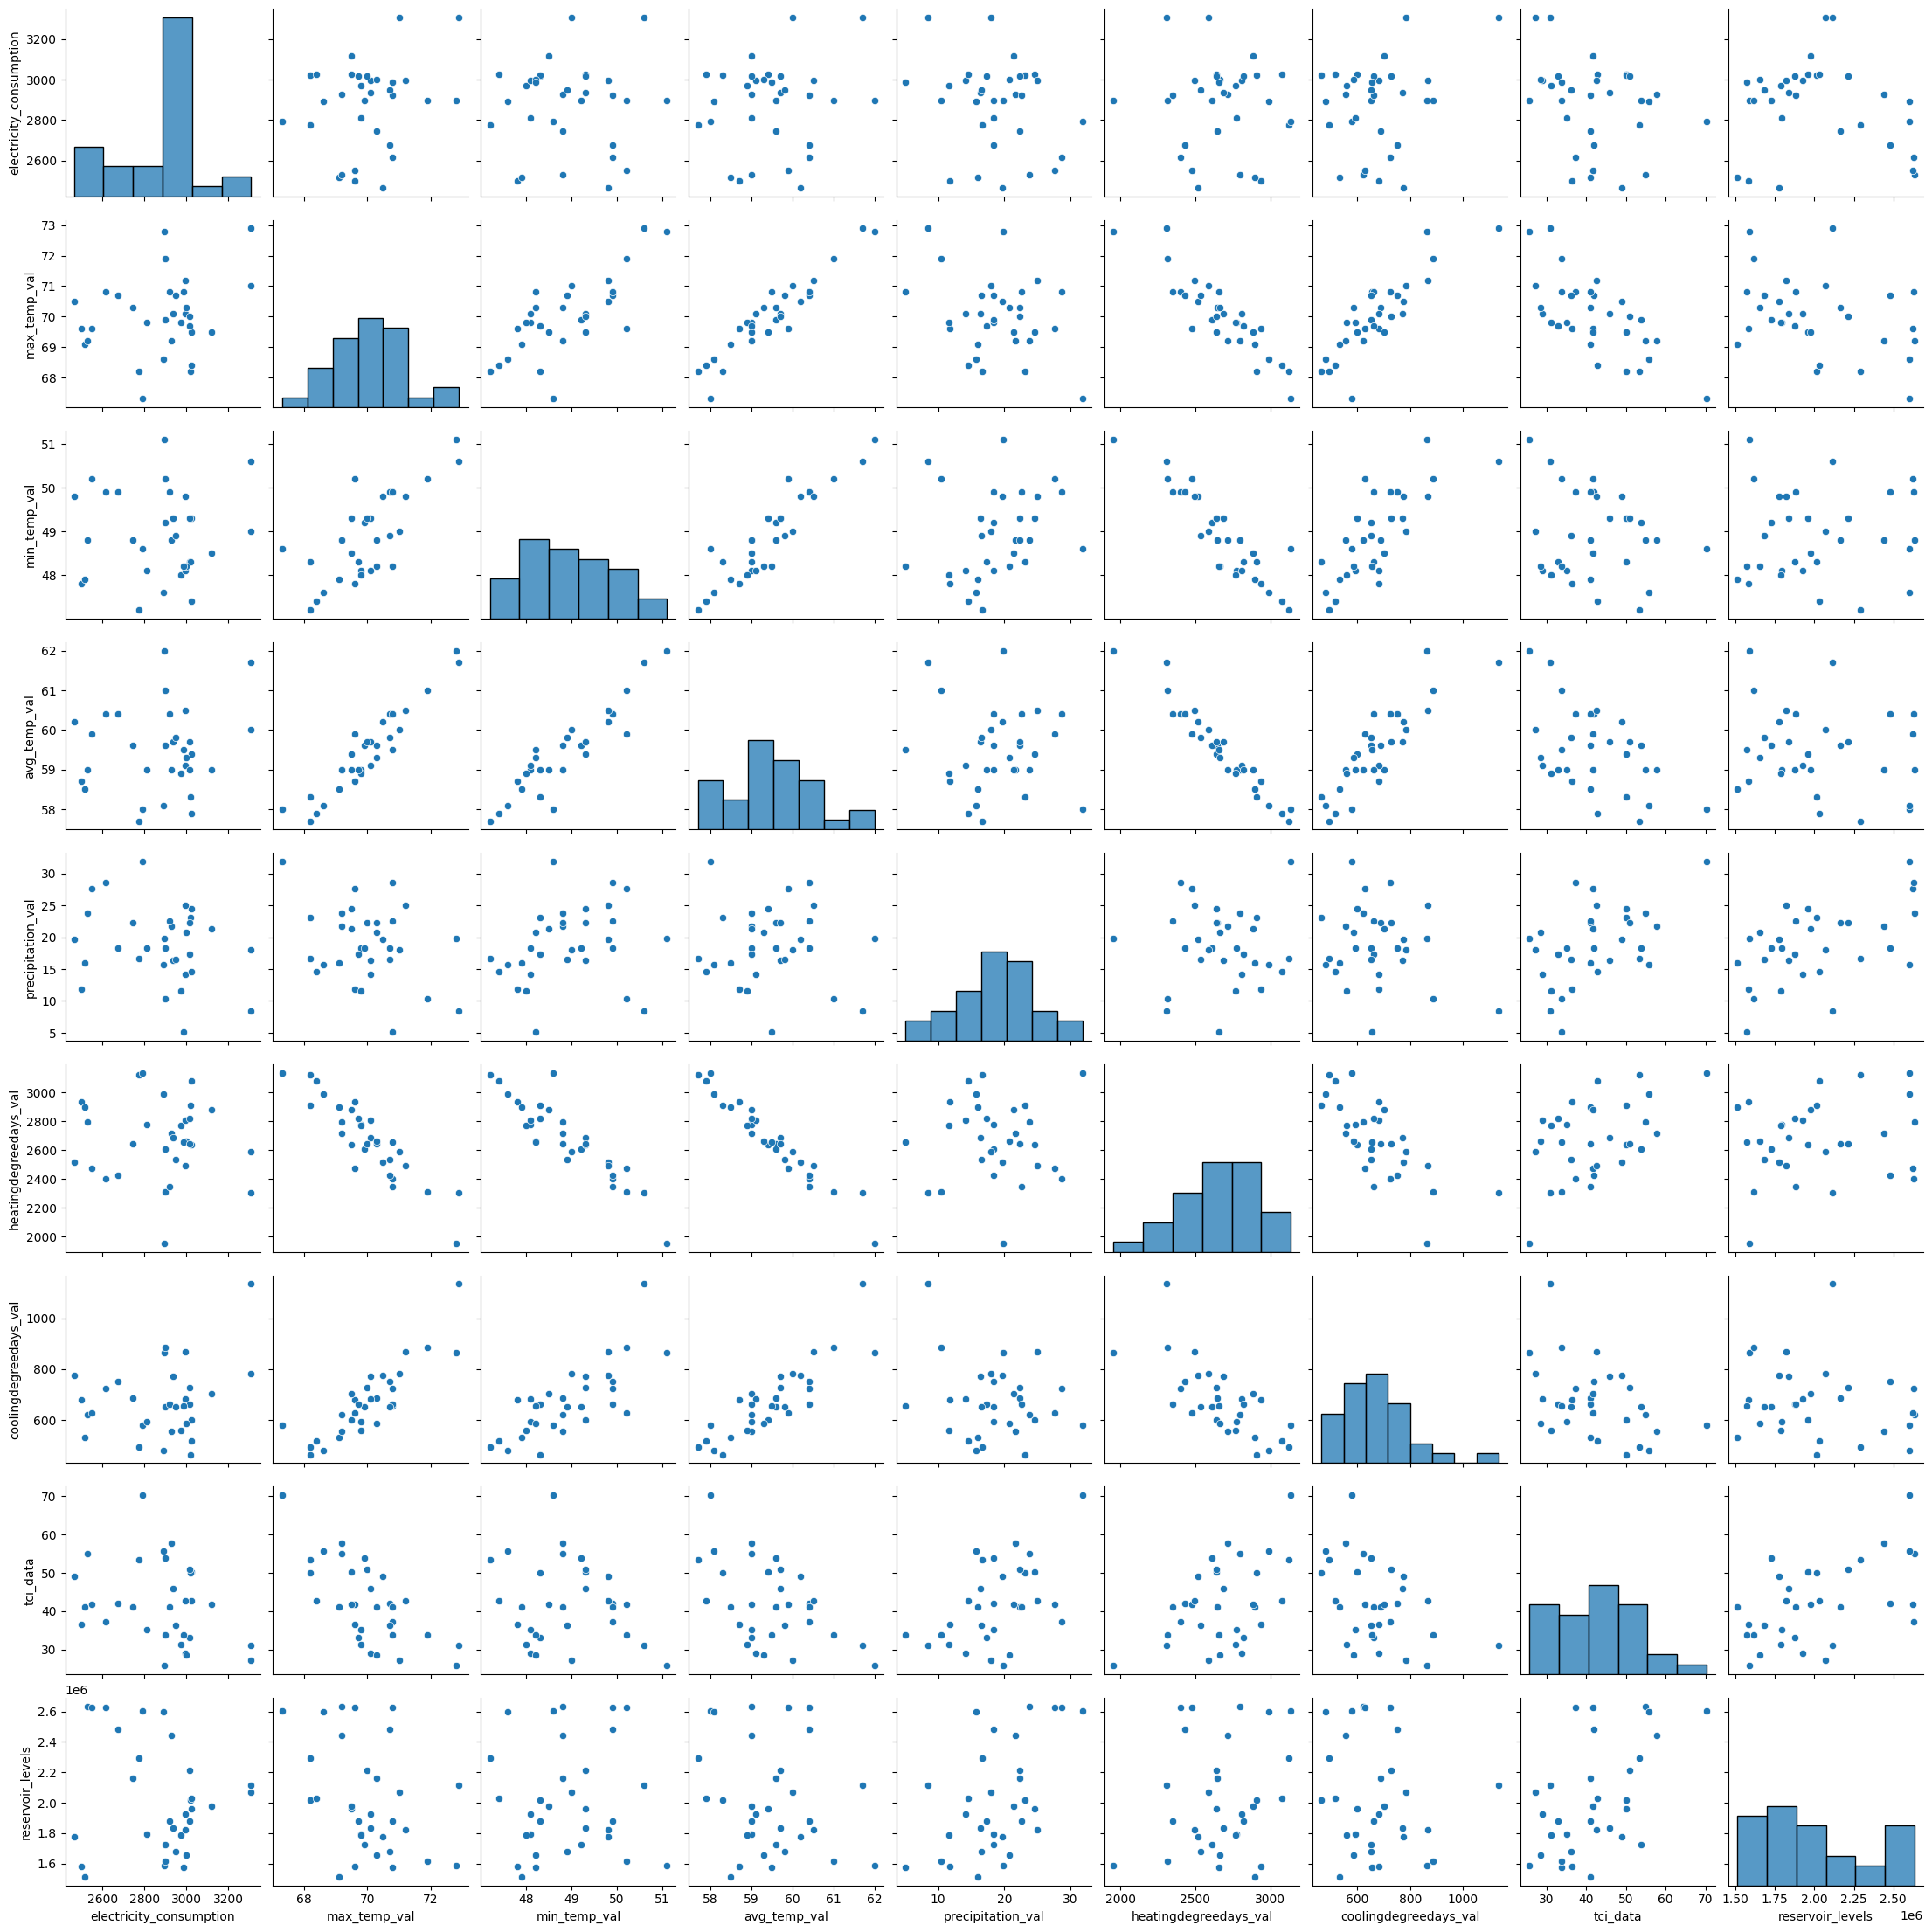

In [52]:
sns.pairplot(new_data)

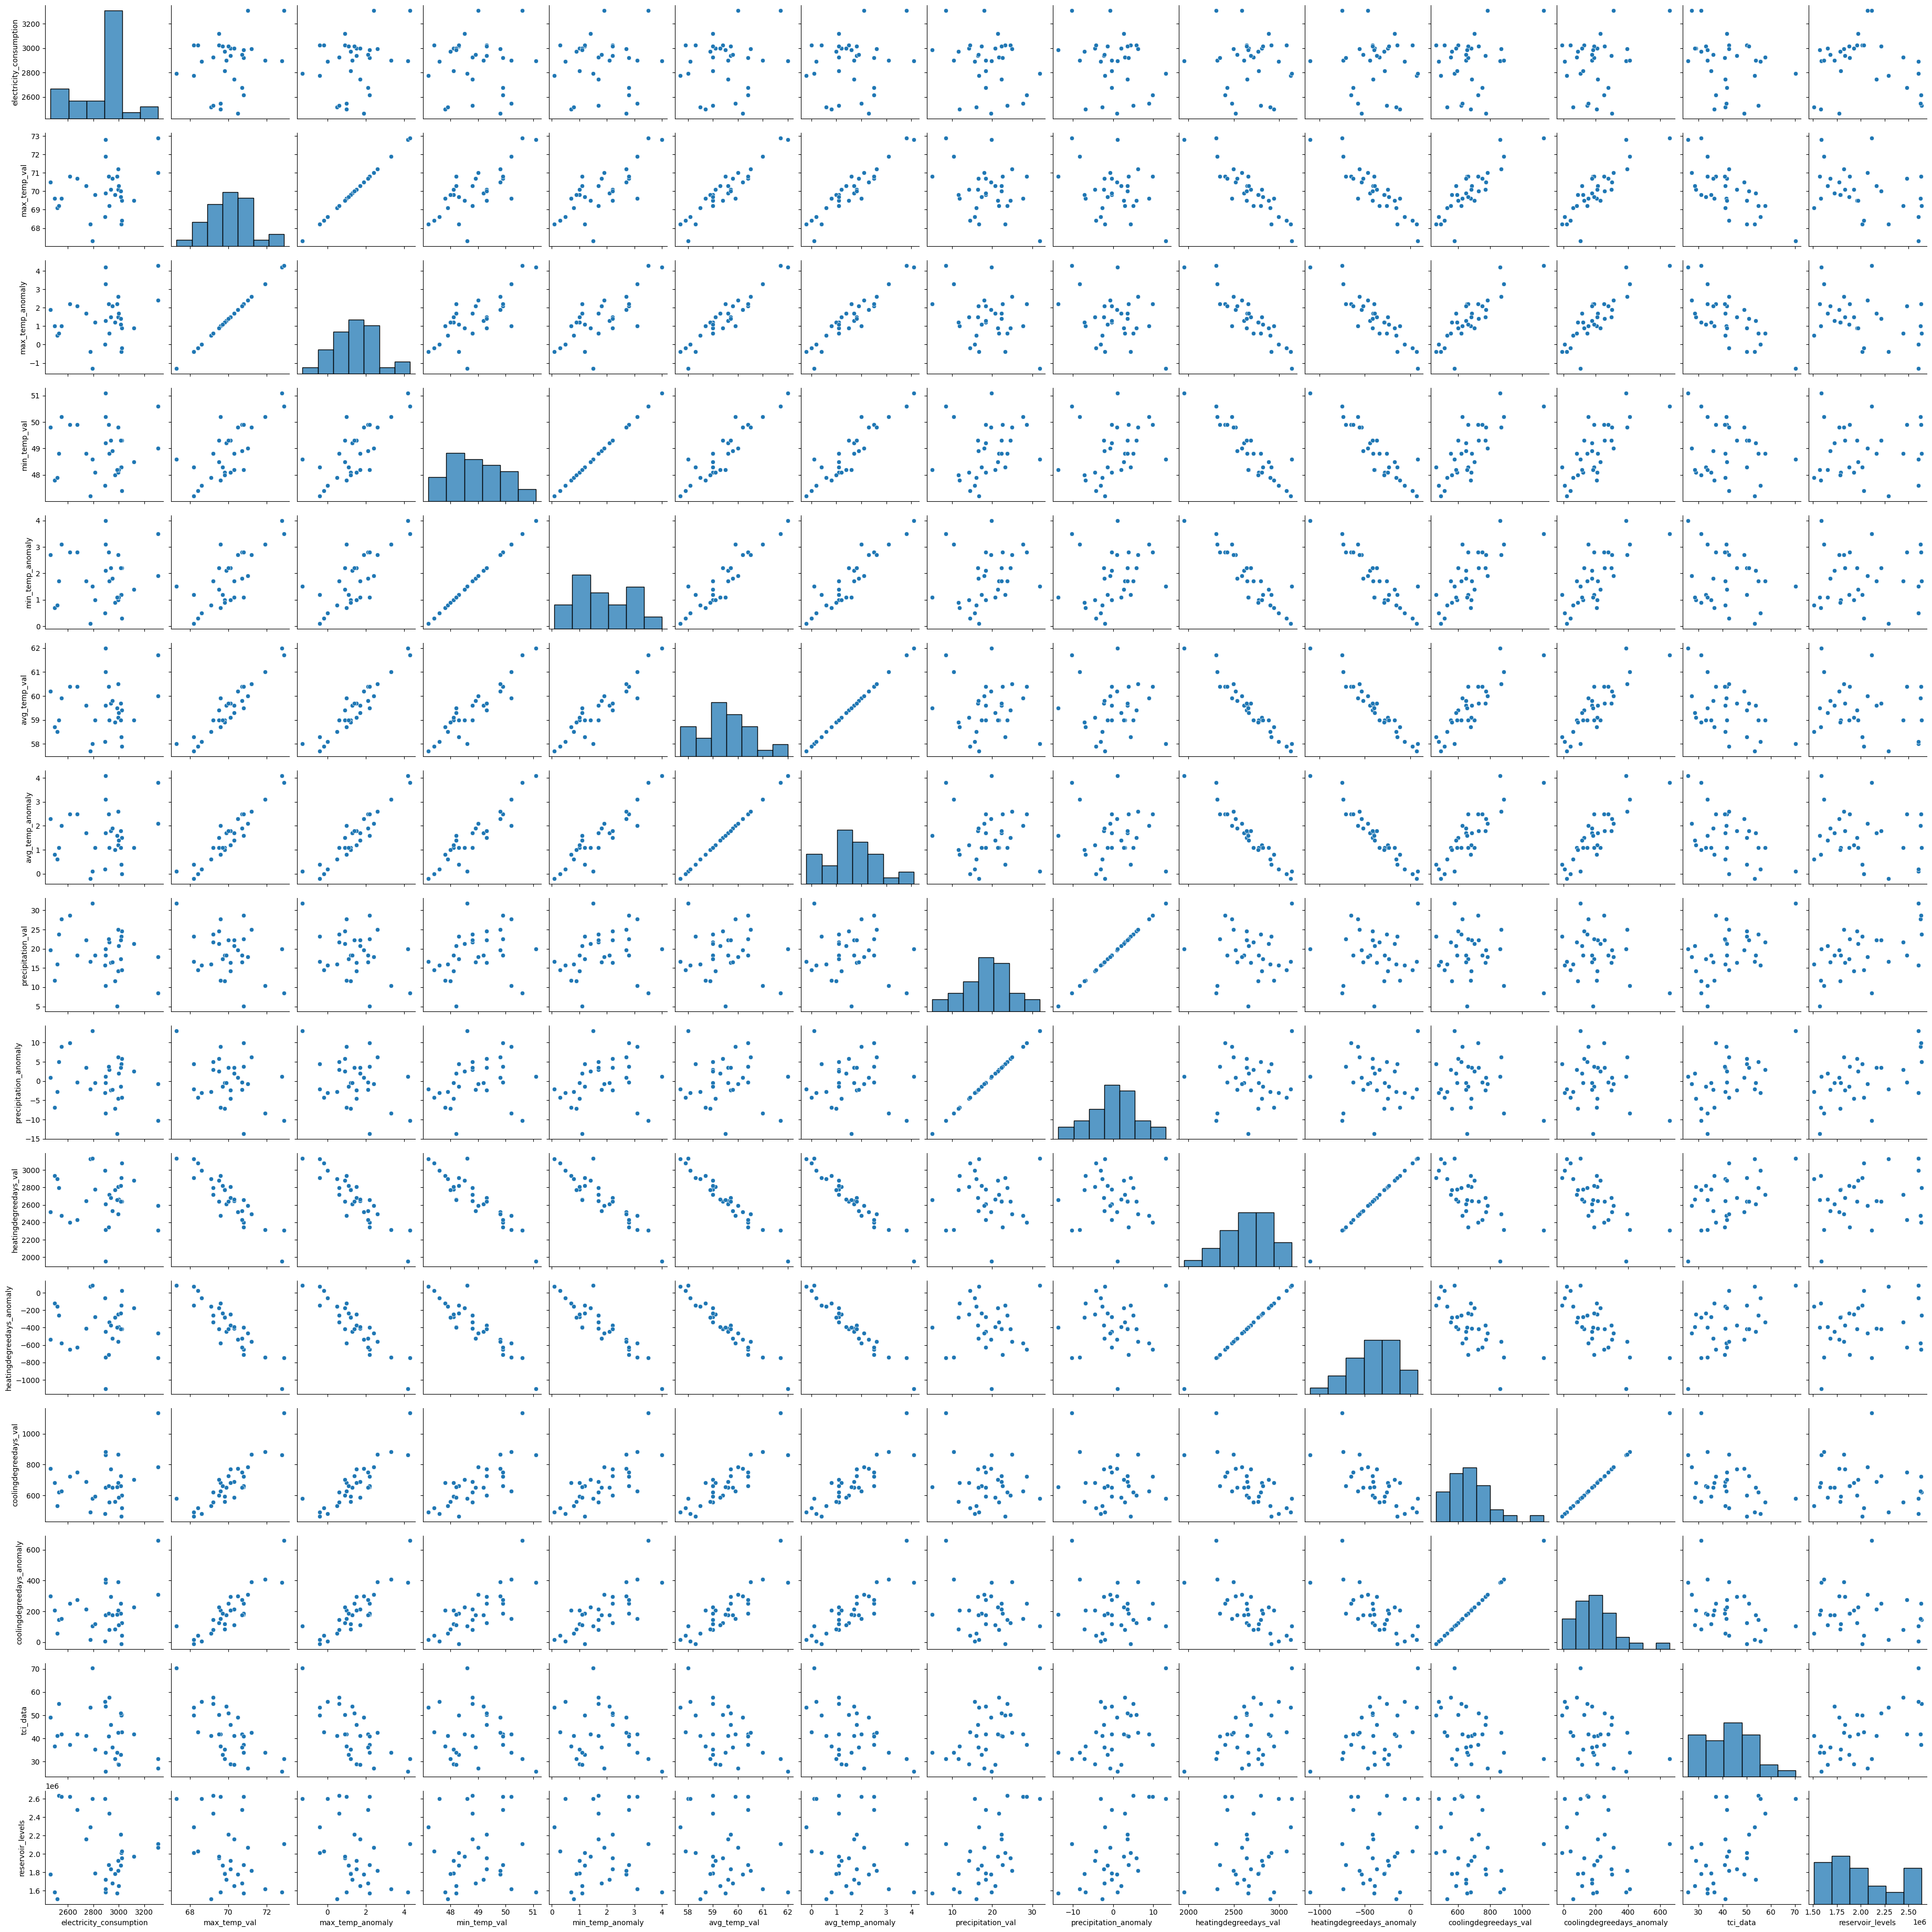

In [53]:
sns.pairplot(new_data_anomaly)

In [54]:
new_data.corr()

electricity_consumption  max_temp_val  min_temp_val  \
electricity_consumption                 1.000000      0.248942      0.015086   
max_temp_val                            0.248942      1.000000      0.733652   
min_temp_val                            0.015086      0.733652      1.000000   
avg_temp_val                            0.146603      0.943066      0.916965   
precipitation_val                      -0.262931     -0.321792      0.242173   
heatingdegreedays_val                  -0.079674     -0.899553     -0.903490   
coolingdegreedays_val                   0.259007      0.856883      0.755160   
tci_data                               -0.286650     -0.689657     -0.176020   
reservoir_levels                       -0.181312     -0.374976      0.047057   

                         avg_temp_val  precipitation_val  \
electricity_consumption      0.146603          -0.262931   
max_temp_val                 0.943066          -0.321792   
min_temp_val                 0.916965           0.242173   
avg_temp_val                 1.000000          -0.062342   
precipitation_val           -0.062342           1.000000   
heatingdegreedays_val       -0.970425           0.001641   
coolingdegreedays_val        0.864368          -0.209586   
tci_data                    -0.490571           0.492952   
reservoir_levels            -0.197477           0.538351   

                         heatingdegreedays_val  coolingdegreedays_val  \
electricity_consumption              -0.079674               0.259007   
max_temp_val                         -0.899553               0.856883   
min_temp_val                         -0.903490               0.755160   
avg_temp_val                         -0.970425               0.864368   
precipitation_val                     0.001641              -0.209586   
heatingdegreedays_val                 1.000000              -0.718875   
coolingdegreedays_val                -0.718875               1.000000   
tci_data                              0.481716              -0.432528   
reservoir_levels                      0.193424              -0.178940   

                         tci_data  reservoir_levels  
electricity_consumption -0.286650         -0.181312  
max_temp_val            -0.689657         -0.374976  
min_temp_val            -0.176020          0.047057  
avg_temp_val            -0.490571         -0.197477  
precipitation_val        0.492952          0.538351  
heatingdegreedays_val    0.481716          0.193424  
coolingdegreedays_val   -0.432528         -0.178940  
tci_data                 1.000000          0.543658  
reservoir_levels         0.543658          1.000000

<Axes: >

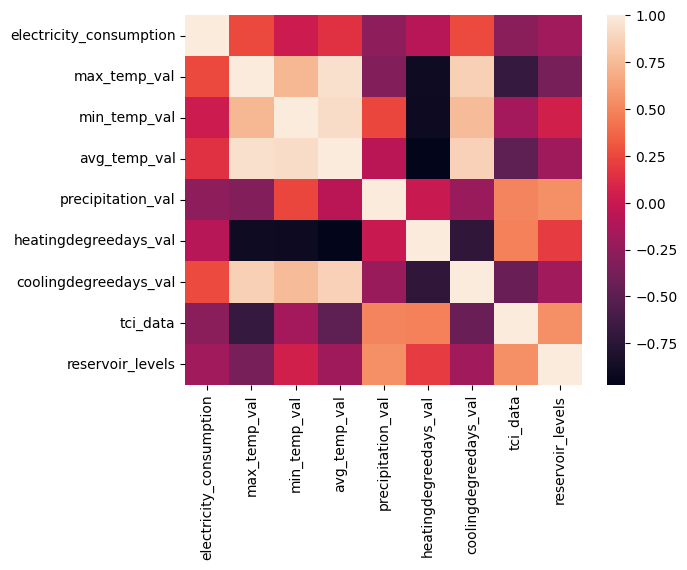

In [55]:
sns.heatmap(new_data.corr())

Based on the plots we do not see any relation of residential electricity consumption with any weather conditions and reservoir water levels.

## Machine Learning Models
### Scale and split data into train and test

In [56]:
x = new_data.loc[:, new_data.columns != 'electricity_consumption']
y = new_data.electricity_consumption

In [57]:
x_anomaly = new_data_anomaly.loc[:, new_data_anomaly.columns != 'electricity_consumption']
y_anomaly = new_data_anomaly.electricity_consumption

### Min-max scaling

In [58]:
new_data_scaler = MinMaxScaler()
x = new_data_scaler.fit_transform(x)

In [59]:
new_data_anomaly_scaler = MinMaxScaler()
x_anomaly = new_data_anomaly_scaler.fit_transform(x_anomaly)

### Train-Test split

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [61]:
x_train_anomaly, x_test_anomaly, y_train_anomaly, y_test_anomaly = train_test_split(
    x_anomaly, y_anomaly, test_size=0.33, random_state=42)

In [62]:
new_data.dtypes

electricity_consumption    float64
max_temp_val               float64
min_temp_val               float64
avg_temp_val               float64
precipitation_val          float64
heatingdegreedays_val        int64
coolingdegreedays_val        int64
tci_data                   float64
reservoir_levels           float64
dtype: object

### Linear Regression

In [63]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [64]:
lr_model.score(x_test, y_test)

-1.0877643516992417

In [65]:
lr_model = LinearRegression()
lr_model.fit(x_train_anomaly, y_train_anomaly)

LinearRegression()

In [66]:
lr_model.score(x_test_anomaly, y_test_anomaly)

-1.9366570790507294

In [67]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [68]:
ridge_model = Ridge()
ridge_model.fit(x_train, y_train)
ridge_model.score(x_test, y_test)

-0.41476910930564115

In [69]:
lasso_model = Lasso()
lasso_model.fit(x_train, y_train)
lasso_model.score(x_test, y_test)

-0.6330895865256945

### SVM

In [70]:
svr_model = SVR()
svr_model.fit(x_train, y_train)
svr_model.score(x_test, y_test)

-0.04973899231804113

In [71]:
svr_model = SVR()
svr_model.fit(x_train_anomaly, y_train_anomaly)
svr_model.score(x_test_anomaly, y_test_anomaly)

-0.05039539311547192

### Decision Tree

In [72]:
dtr_model = DecisionTreeRegressor(random_state=42)
dtr_model.fit(x_train, y_train)
dtr_model.score(x_test, y_test)

-1.5198989146989983

In [73]:
dtr_model = DecisionTreeRegressor(random_state=42)
dtr_model.fit(x_train_anomaly, y_train_anomaly)
dtr_model.score(x_test_anomaly, y_test_anomaly)

-1.5203067811786726

## Post-PCA

In [74]:
pca = PCA()
pca.fit(x)
np.cumsum(pca.explained_variance_ratio_)

array([0.5572635 , 0.84768672, 0.92372478, 0.97267125, 0.99460507,
       0.99989713, 0.99996167, 1.        ])

In [75]:
pca_anomaly = PCA()
pca_anomaly.fit(x_anomaly)
np.cumsum(pca_anomaly.explained_variance_ratio_)

array([0.62647892, 0.86673511, 0.93175568, 0.9690131 , 0.99410756,
       0.99987633, 0.99995392, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [76]:
x_new = pca.transform(x)[:, :4]
x_new_anomaly = pca_anomaly.transform(x_anomaly)[:, :4]

### Train-Test split

In [77]:
x_new_train, x_new_test, y_train, y_test = train_test_split(x_new, y, test_size=0.33, random_state=42)

In [78]:
x_new_train_anomaly, x_new_test_anomaly, y_train_anomaly, y_test_anomaly = train_test_split(
    x_new_anomaly, y_anomaly, test_size=0.33, random_state=42)

### Linear Regression

In [79]:
lr_model = LinearRegression()
lr_model.fit(x_new_train, y_train)

LinearRegression()

In [80]:
lr_model.score(x_new_test, y_test)

-0.7591519131428233

In [81]:
lr_model = LinearRegression()
lr_model.fit(x_new_train_anomaly, y_train_anomaly)

LinearRegression()

In [82]:
lr_model.score(x_new_test_anomaly, y_test_anomaly)

-0.7002455268555319

### SVM

In [83]:
svr_model = SVR()
svr_model.fit(x_new_train, y_train)
svr_model.score(x_new_test, y_test)

-0.04957205115781682

In [84]:
svr_model = SVR()
svr_model.fit(x_new_train_anomaly, y_train_anomaly)
svr_model.score(x_new_test_anomaly, y_test_anomaly)

-0.049792106861113794

In [85]:
mean_squared_error(svr_model.predict(x_new_test_anomaly), y_test_anomaly)

37969.47090055673

In [86]:
svr1_model = SVR(C=1e-5)
svr1_model.fit(x_new_train_anomaly, y_train_anomaly)
svr1_model.score(x_new_test_anomaly, y_test_anomaly)

-0.04205023862512847

In [87]:
mean_squared_error(svr1_model.predict(x_new_test_anomaly), y_test_anomaly)

37689.458659293916

In [88]:
svr2_model = SVR(C=1e-5)
svr2_model.fit(x_new_train, y_train)
svr2_model.score(x_new_test, y_test)

-0.0420502363396007

In [89]:
mean_squared_error(svr2_model.predict(x_new_test), y_test)

37689.458576629666

### Decision Tree

In [90]:
dtr_model = DecisionTreeRegressor(random_state=42, min_samples_split=3)
dtr_model.fit(x_new_train, y_train)
dtr_model.score(x_new_test, y_test)

-0.7690608914170516

In [91]:
from sklearn.tree import plot_tree

[Text(0.6428571428571429, 0.9375, 'x[1] <= 0.419\nsquared_error = 48999.854\nsamples = 21\nvalue = 2866.23'),
 Text(0.42857142857142855, 0.8125, 'x[3] <= 0.008\nsquared_error = 37885.497\nsamples = 17\nvalue = 2930.765'),
 Text(0.21428571428571427, 0.6875, 'x[3] <= -0.016\nsquared_error = 44027.191\nsamples = 7\nvalue = 2817.51'),
 Text(0.14285714285714285, 0.5625, 'x[2] <= -0.234\nsquared_error = 33595.74\nsamples = 6\nvalue = 2867.893'),
 Text(0.07142857142857142, 0.4375, 'squared_error = 46837.361\nsamples = 2\nvalue = 2681.419'),
 Text(0.21428571428571427, 0.4375, 'x[0] <= 0.177\nsquared_error = 895.692\nsamples = 4\nvalue = 2961.13'),
 Text(0.14285714285714285, 0.3125, 'squared_error = 30.271\nsamples = 2\nvalue = 2931.62'),
 Text(0.2857142857142857, 0.3125, 'squared_error = 19.472\nsamples = 2\nvalue = 2990.639'),
 Text(0.2857142857142857, 0.5625, 'squared_error = -0.0\nsamples = 1\nvalue = 2515.21'),
 Text(0.6428571428571429, 0.6875, 'x[1] <= 0.061\nsquared_error = 18322.41\nsam

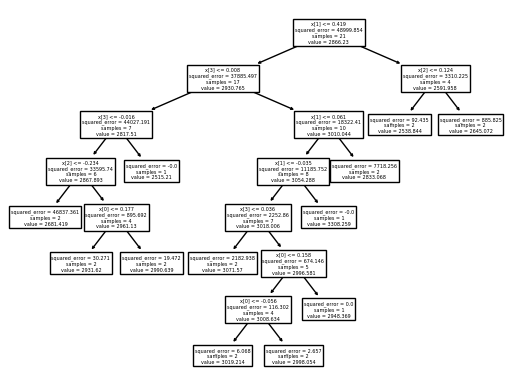

In [92]:
plot_tree(dtr_model)

In [93]:
dtr_model = DecisionTreeRegressor(random_state=42)
dtr_model.fit(x_new_train_anomaly, y_train_anomaly)
dtr_model.score(x_new_test_anomaly, y_test_anomaly)

-0.9070375126515238

In [94]:
mean_squared_error(dtr_model.predict(x_new_test_anomaly), y_test_anomaly)

68974.80450619521

### Random Forest

In [95]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42, min_samples_split=3)
rf_model.fit(x_new_train, y_train)
rf_model.score(x_new_test, y_test)

-0.20576027708514877

In [96]:
rf_model = RandomForestRegressor(random_state=42, min_samples_split=3)
rf_model.fit(x_new_train_anomaly, y_train)
rf_model.score(x_new_test_anomaly, y_test)

-0.0541837634587885

In [97]:
mean_squared_error(rf_model.predict(x_new_test_anomaly), y_test)

38128.31080447754

In [98]:
rf_model = RandomForestRegressor(min_samples_split=3, random_state=42, max_depth=3)
rf_model.fit(x_new_train_anomaly, y_train)
rf_model.score(x_new_test_anomaly, y_test)

-0.00754567775179793

In [99]:
mean_squared_error(rf_model.predict(x_new_test_anomaly), y_test)

36441.4783101811

## Cross Validation
Since our dataset is very small

In [100]:
x.shape

(32, 8)

In [101]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RandomForestRegressor(n_estimators=200 ,min_samples_split=3, random_state=42, max_depth=3),
                         X = x_new_anomaly , y = y , cv = 16)

In [102]:
scores

array([-2.85797091e+03, -1.66175879e+02, -2.39992629e+00, -5.69273903e+01,
       -3.33707972e+00, -4.96074991e+00, -3.94531544e+00, -5.05964593e+00,
       -8.87996472e+00, -4.61864700e+01, -1.88165897e+04, -6.74192042e+02,
       -3.89177220e+03, -9.45503145e+00, -1.88385061e+01, -1.61680173e+07])

It seems that we have overfit (See the last entry)

In [103]:
np.mean(scores)

-1012161.4973051158

### Leave One Out

Since our data is very small, it makes sense to use Leave One Out cross-validation to ensure that we consider each data point.

In [104]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
predictions = []
for loo_train_indices, loo_test_indices in loo.split(x_new_anomaly):
    loo_x_train, loo_x_test = x_new_anomaly[loo_train_indices], x_new_anomaly[loo_test_indices]
    loo_y_train, loo_y_test = y.values[loo_train_indices], y.values[loo_test_indices]
    rf_loo_model = RandomForestRegressor(n_estimators=2000, max_depth=3,
                                         min_samples_split=3, min_samples_leaf=5, bootstrap=True,
                                         random_state=42, n_jobs=-1)
    rf_loo_model.fit(loo_x_train, loo_y_train)
    predictions.append(mean_squared_error(rf_loo_model.predict(loo_x_test), loo_y_test))

In [105]:
predictions

[192429.08955735527,
 160614.1625858736,
 224490.06816001513,
 111029.63423530065,
 33593.382577807,
 84509.31423964235,
 50719.73803098504,
 37225.682037710394,
 950.4705414480987,
 1919.0793422079644,
 28625.59048667501,
 23338.769416228748,
 20107.896264938445,
 12.023789429179027,
 718.7922407566418,
 45295.311401555955,
 87245.35156894727,
 5770.247999658596,
 107.10473299237674,
 9628.42534827854,
 54908.01887047296,
 24730.235361797808,
 4547.429237760099,
 45.932477535709204,
 966.524541719257,
 6972.368418740644,
 5668.520679410646,
 32731.674772658513,
 1.0589629439377934,
 58019.91802878935,
 172770.71506091,
 153069.0889260886]

In [106]:
np.mean(predictions)

51023.8006217698

In [107]:
predictions = []
for loo_train_indices, loo_test_indices in loo.split(x_new_anomaly):
    loo_x_train, loo_x_test = x_new_anomaly[loo_train_indices], x_new_anomaly[loo_test_indices]
    loo_y_train, loo_y_test = y.values[loo_train_indices], y.values[loo_test_indices]
    svr_loo_model = SVR(C=1e-5)
    svr_loo_model.fit(loo_x_train, loo_y_train)
    predictions.append(mean_squared_error(svr_loo_model.predict(loo_x_test), loo_y_test))
np.mean(predictions)

47804.45166035088

In [108]:
predictions

[183057.663268935,
 168845.41284655497,
 212629.73545740588,
 157520.63018081323,
 22967.907095185506,
 142627.08283010623,
 96602.35423746696,
 63143.439900311816,
 18167.481909329083,
 1249.6679522179024,
 27.00680991383776,
 32726.26864129078,
 13107.289128690107,
 262.45848444727966,
 799.7079844322652,
 10889.740863364928,
 38955.262081336085,
 2599.7589697618505,
 5700.6566358003,
 9183.295630226541,
 10151.82459777427,
 10800.832180927842,
 6203.525667287837,
 4264.775458552556,
 1015.3537233248912,
 819.3341095322625,
 27.006809843985273,
 5495.374181594185,
 753.3638433696437,
 8925.103508608141,
 150192.20348376763,
 150030.93465905465]

In [109]:
predictions = []
for loo_train_indices, loo_test_indices in loo.split(x_new):
    loo_x_train, loo_x_test = x_new[loo_train_indices], x_new[loo_test_indices]
    loo_y_train, loo_y_test = y.values[loo_train_indices], y.values[loo_test_indices]
    svr_loo_model = SVR(C=1e-5)
    svr_loo_model.fit(loo_x_train, loo_y_train)
    predictions.append(mean_squared_error(svr_loo_model.predict(loo_x_test), loo_y_test))
np.mean(predictions)

47804.4535472734

In [110]:
predictions = []
for loo_train_indices, loo_test_indices in loo.split(x):
    loo_x_train, loo_x_test = x[loo_train_indices], x[loo_test_indices]
    loo_y_train, loo_y_test = y.values[loo_train_indices], y.values[loo_test_indices]
    svr_loo_model = SVR(C=1e-5)
    svr_loo_model.fit(loo_x_train, loo_y_train)
    predictions.append(mean_squared_error(svr_loo_model.predict(loo_x_test), loo_y_test))
np.mean(predictions)

47804.453610937504

It seems that PCA might have been unnecessary as we get same results when using the original data (without anomaly columns).

## Relationship between gasoline prices, storms, and electricity consumption

In the following section, I try to understand if there is any clear correlation between the gasprices, adverse climate conditions (storms), and electricity consumption.

In [111]:
import nasdaqdatalink

In [112]:
rbob_la_prices = nasdaqdatalink.get('FRED/MRGASLA')

In [113]:
rbob_la_prices

Value
Date             
2003-06-01  1.072
2003-07-01  0.965
2003-08-01  1.315
2003-09-01  0.949
2003-10-01  0.996
...           ...
2021-10-01  2.535
2021-11-01  2.530
2021-12-01  2.315
2022-01-01  2.548
2022-02-01  2.818

[225 rows x 1 columns]

Notice that the date format is yyyy-mm-dd, where dd is always 01

Storm Events Database

Search Results for Alameda County, California

Event Types: Avalanche, Blizzard, Cold/Wind Chill, Dense Fog, Drought, Excessive Heat, Extreme Cold/Wind Chill, Freezing Fog, Frost/Freeze, Hail, Heat, Heavy Rain, Heavy Snow, Hurricane (Typhoon), Ice Storm, Sleet, Thunderstorm Wind, Tornado, Wildfire, Winter Storm, Winter Weather

Alameda county contains the following zones:
San Francisco Bay Shoreline, East Bay Interior Valleys, East Bay Hills and the Diablo Range

99 events were reported between 01/01/1990 and 12/31/2021 (11688 days) 

In [114]:
import pandas as pd

In [115]:
storm_data = pd.read_csv('storm_data_search_results.csv', delimiter=',')

In [116]:
storm_data

EVENT_ID                                 CZ_NAME_STR BEGIN_LOCATION  \
0    9991320                                 ALAMEDA CO.                  
1   10317116                                 ALAMEDA CO.      Livermore   
2    5575575                                 ALAMEDA CO.        OAKLAND   
3    5575576                                 ALAMEDA CO.        OAKLAND   
4    5636121                                 ALAMEDA CO.        HAYWARD   
..       ...                                         ...            ...   
94    947502                                 ALAMEDA CO.     PLEASANTON   
95    961455            EAST BAY INTERIOR VALLEYS (ZONE)                  
96    966983            EAST BAY INTERIOR VALLEYS (ZONE)                  
97    966985            EAST BAY INTERIOR VALLEYS (ZONE)                  
98    966975  EAST BAY HILLS AND THE DIABLO RANGE (ZONE)                  

    BEGIN_DATE  BEGIN_TIME      EVENT_TYPE MAGNITUDE TOR_F_SCALE  \
0   12/17/1992        1230         Tornado         0          F0   
1   04/25/1994        1150         Tornado         0          F0   
2   12/05/1996           0      Heavy Rain                         
3   12/05/1996         415      Heavy Rain                         
4   01/11/1998         900      Heavy Rain                         
..         ...         ...             ...       ...         ...   
94  03/15/2021        1500            Hail      0.25               
95  06/17/2021        1500            Heat                         
96  07/10/2021        1055  Excessive Heat                         
97  07/11/2021         822        Wildfire                         
98  07/11/2021         950  Excessive Heat                         

    DEATHS_DIRECT  INJURIES_DIRECT  ...  END_LOCATION    END_DATE END_TIME  \
0               0                0  ...                12/17/1992     1230   
1               0                0  ...                04/25/1994     1150   
2               0                0  ...       OAKLAND  12/05/1996     1600   
3               0                0  ...       OAKLAND  12/05/1996      416   
4               1                0  ...       HAYWARD  01/11/1998      900   
..            ...              ...  ...           ...         ...      ...   
94              0                0  ...    PLEASANTON  03/15/2021     1515   
95              0                0  ...                06/17/2021     1600   
96              0                0  ...                07/10/2021     2355   
97              0                0  ...                07/11/2021     1522   
98              0                0  ...                07/11/2021     2100   

   BEGIN_LAT BEGIN_LON END_LAT  END_LON  \
0      37.73   -122.15                    
1                                         
2                                         
3                                         
4                                         
..       ...       ...     ...      ...   
94     37.67   -121.88   37.67  -121.88   
95                                        
96                                        
97                                        
98                                        

                                      EVENT_NARRATIVE  \
0                                                 NaN   
1   A small tornado skipped across a residential h...   
2                                                 NaN   
3                                                 NaN   
4   rain slick road and poor visibility caused aut...   
..                                                ...   
94  Spotter reported pea sized hail in north Pleas...   
95  Livermore station broke a daily record at 107 ...   
96  Byron ASOS reached a daytime high of 113 degre...   
97  The Diablo Fire broke out in the morning on th...   
98  Mesonet (PG&E) station at San Jose Mines Rd ha...   

                                    EPISODE_NARRATIVE  ABSOLUTE_ROWNUMBER  
0                                                 NaN                  

In [117]:
filtered_storm_data = storm_data[['BEGIN_DATE', 'EVENT_TYPE']].copy()

In [118]:
filtered_storm_data.head(10)

BEGIN_DATE    EVENT_TYPE
0  12/17/1992       Tornado
1  04/25/1994       Tornado
2  12/05/1996    Heavy Rain
3  12/05/1996    Heavy Rain
4  01/11/1998    Heavy Rain
5  02/09/1999          Hail
6  07/21/2006          Heat
7  07/21/2006          Heat
8  07/22/2006          Heat
9  01/06/2007  Frost/Freeze

#### Dropping duplicates

In [119]:
filtered_storm_data.drop_duplicates(inplace=True)

Create a dictionary with monthly summary. Example: {month:\[event1, event2, etc.\]}

In [120]:
filtered_storm_data.shape

(67, 2)

Aggregate monthly

In [121]:
def monthly_aggregate(date):
    # Convert mm/dd/yyyy to yyyy/mm/dd
    date =  date.split('/') # mm dd yyyy
    return '-'.join([date[2], date[0], '01'])
filtered_storm_data['BEGIN_DATE'].apply(monthly_aggregate)

0     1992-12-01
1     1994-04-01
2     1996-12-01
4     1998-01-01
5     1999-02-01
         ...    
94    2021-03-01
95    2021-06-01
96    2021-07-01
97    2021-07-01
98    2021-07-01
Name: BEGIN_DATE, Length: 67, dtype: object

In [122]:
filtered_storm_data['BEGIN_DATE'] = filtered_storm_data['BEGIN_DATE'].apply(monthly_aggregate)

In [123]:
import collections
event_dict = collections.defaultdict(list)
for i in range(filtered_storm_data.shape[0]):
    a, b = filtered_storm_data.iloc[i]
    event_dict[a].append(b)

In [124]:
event_dict

defaultdict(list,
            {'1992-12-01': ['Tornado'],
             '1994-04-01': ['Tornado'],
             '1996-12-01': ['Heavy Rain'],
             '1998-01-01': ['Heavy Rain'],
             '1999-02-01': ['Hail'],
             '2006-07-01': ['Heat', 'Heat'],
             '2007-01-01': ['Frost/Freeze'],
             '2007-07-01': ['Heat'],
             '2008-11-01': ['Heavy Rain'],
             '2008-12-01': ['Frost/Freeze'],
             '2009-05-01': ['Heat'],
             '2009-06-01': ['Heat'],
             '2009-10-01': ['Heavy Rain'],
             '2009-12-01': ['Winter Weather'],
             '2010-10-01': ['Heavy Rain'],
             '2012-03-01': ['Heavy Rain'],
             '2015-02-01': ['Heavy Rain'],
             '2017-01-01': ['Hail', 'Hail'],
             '2017-04-01': ['Thunderstorm Wind'],
             '2017-06-01': ['Heat', 'Heat'],
             '2018-01-01': ['Hail'],
             '2018-03-01': ['Hail', 'Hail', 'Hail'],
             '2018-04-01': ['Hail'],
    

In [125]:
event_series = pd.Series(event_dict)

In [126]:
# event_series.index = event_series.index.astype(np.datetime64)

In [127]:
event_series.index

Index(['1992-12-01', '1994-04-01', '1996-12-01', '1998-01-01', '1999-02-01',
       '2006-07-01', '2007-01-01', '2007-07-01', '2008-11-01', '2008-12-01',
       '2009-05-01', '2009-06-01', '2009-10-01', '2009-12-01', '2010-10-01',
       '2012-03-01', '2015-02-01', '2017-01-01', '2017-04-01', '2017-06-01',
       '2018-01-01', '2018-03-01', '2018-04-01', '2018-11-01', '2018-12-01',
       '2019-01-01', '2019-02-01', '2019-04-01', '2019-06-01', '2019-08-01',
       '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-03-01',
       '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2021-01-01',
       '2021-03-01', '2021-06-01', '2021-07-01'],
      dtype='object')

In [128]:
import plotly

In [129]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=rbob_la_prices.index, y=rbob_la_prices.Value,
                    mode='lines+markers',
                    name='RBOB Gas Price'))
event_x = [_ for _ in event_series.index if _ in rbob_la_prices.index]
event_y = [rbob_la_prices.Value.loc[_] for _ in event_x]
fig.add_trace(go.Scatter(x=event_x, y=event_y,
                    mode='markers',
                    name='Storm Events',
                    text=event_series[event_x]))


In [ ]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(x=electricity_consumption.index, y=electricity_consumption,
                    mode='lines+markers',
                    name='Electricity Consumption'))
event_x1 = [int(_[:4]) for _ in event_series.index.to_list()]
fig1.add_trace(go.Scatter(x=event_x1, y=electricity_consumption[event_x1],
                    mode='markers',
                    name='Storm Events'))

## Try using monthly data

So far since we had the annual electricity consumption, I tried aggregating the environment factors annually. As we saw, our machine learning models performed poorly. I now try to use monthly information instead to avoid any additional information loss.

In [ ]:
monthly_avg_temp = pd.read_csv("monthly avg temp 1895-2022(7).csv", skiprows=4)
monthly_max_temp = pd.read_csv("monthly max temp 1895-2022(7).csv", skiprows=4)
monthly_min_temp = pd.read_csv("monthly min temp 1895-2022(7).csv", skiprows=4)
monthly_precipitation = pd.read_csv("monthly precipitation 1895-2022(7).csv", skiprows=4)
monthly_heatingdegreedays = pd.read_csv("monthly heating degree days 1895-2022(7).csv", skiprows=4)
monthly_coolingdegreedays = pd.read_csv("monthly cooling degree days 1895-2022(7).csv", skiprows=4)

Converting to monthly columns:

The following function convert the entries into annual rows, with months as columns.

From:


`
    Date 	Value 	Anomaly
0 	189501 	56.6 	-1.3
1 	189502 	57.5 	-0.4
2 	189503 	56.6 	-1.3
3 	189504 	57.3 	-0.6
`

To:

Year, 1, 2, 3, 4, ... , 12

In [133]:
def convert_monthly_columns(df):
    df['Month'] = df['Date'].apply(lambda x: x%100)
    df['Year'] = df['Date'].apply(lambda x: x//100)
    return df.pivot(index="Year", columns="Month", values=["Value", "Anomaly"])

In [134]:
n_monthly_avg_temp = convert_monthly_columns(monthly_avg_temp)
n_monthly_max_temp = convert_monthly_columns(monthly_max_temp)
n_monthly_min_temp = convert_monthly_columns(monthly_min_temp)
n_monthly_precipitation = convert_monthly_columns(monthly_precipitation)
n_monthly_heatingdegreedays = convert_monthly_columns(monthly_heatingdegreedays)
n_monthly_coolingdegreedays = convert_monthly_columns(monthly_coolingdegreedays)

In [135]:
n_monthly_avg_temp

Value                                                        ...  \
Month    1     2     3     4     5     6     7     8     9     10  ...   
Year                                                               ...   
1895   45.2  50.0  50.6  54.5  59.3  65.9  67.4  67.3  63.7  60.2  ...   
1896   49.2  51.1  52.7  50.6  57.4  65.3  71.0  68.1  64.5  60.8  ...   
1897   44.3  46.7  46.2  57.0  62.0  64.9  69.1  68.0  66.3  59.0  ...   
1898   42.4  50.0  49.4  57.4  56.7  66.6  69.6  69.3  66.1  62.0  ...   
1899   50.1  49.1  50.6  55.4  56.9  65.5  68.0  66.2  66.6  58.9  ...   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2018   51.1  51.5  51.9  56.8  60.3  67.4  72.6  69.8  67.4  63.7  ...   
2019   50.8  46.2  51.9  59.3  58.8  69.0  70.5  72.8  68.7  62.3  ...   
2020   48.9  53.9  51.5  57.6  64.6  69.2  71.3  75.2  73.1  69.8  ...   
2021   50.2  51.8  51.9  58.1  63.1  68.8  72.6  72.4  70.4  61.1  ...   
2022   50.6  52.3  55.7  57.1  62.2  69.9  70.2  73.2  72.8  65.0  ...   

      Anomaly                                               
Month      3    4    5    6    7    8    9    10   11   12  
Year                                                        
1895     -1.3 -0.7 -0.5  0.9 -1.7 -1.6 -3.5 -1.3 -1.9 -2.7  
1896      0.8 -4.6 -2.4  0.3  1.9 -0.8 -2.7 -0.7 -3.1  2.0  
1897     -5.7  1.8  2.2 -0.1  0.0 -0.9 -0.9 -2.5 -2.9 -1.1  
1898     -2.5  2.2 -3.1  1.6  0.5  0.4 -1.1  0.5 -0.7 -1.9  
1899     -1.3  0.2 -2.9  0.5 -1.1 -2.7 -0.6 -2.6  0.8 -1.2  
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2018      0.0  1.6  0.5  2.4  3.5  0.9  0.2  2.2  2.9  2.1  
2019      0.0  4.1 -1.0  4.0  1.4  3.9  1.5  0.8  2.9  2.8  
2020     -0.4  2.4  4.8  4.2  2.2  6.3  5.9  8.3  1.7  3.9  
2021      0.0  2.9  3.3  3.8  3.5  3.5  3.2 -0.4  3.6  0.0  
2022      3.8  1.9  2.4  4.9  1.1  4.3  5.6  3.5 -2.1 -0.1  

[128 rows x 24 columns]

In [136]:
columns=[
    "avg_temp_val", "avg_temp_anomaly",
    "max_temp_val", "max_temp_anomaly",
    "min_temp_val", "min_temp_anomaly",
    "precipitation_val", "precipitation_anomaly",
    "heatday_val", "heatday_anomaly",
    "coolday_val", "coolday_anomaly"]
monthly_df_cols = [_+'_{}'.format(i) for _ in columns for i in range(1, 13)]

In [137]:
monthly_df_cols

['avg_temp_val_1',
 'avg_temp_val_2',
 'avg_temp_val_3',
 'avg_temp_val_4',
 'avg_temp_val_5',
 'avg_temp_val_6',
 'avg_temp_val_7',
 'avg_temp_val_8',
 'avg_temp_val_9',
 'avg_temp_val_10',
 'avg_temp_val_11',
 'avg_temp_val_12',
 'avg_temp_anomaly_1',
 'avg_temp_anomaly_2',
 'avg_temp_anomaly_3',
 'avg_temp_anomaly_4',
 'avg_temp_anomaly_5',
 'avg_temp_anomaly_6',
 'avg_temp_anomaly_7',
 'avg_temp_anomaly_8',
 'avg_temp_anomaly_9',
 'avg_temp_anomaly_10',
 'avg_temp_anomaly_11',
 'avg_temp_anomaly_12',
 'max_temp_val_1',
 'max_temp_val_2',
 'max_temp_val_3',
 'max_temp_val_4',
 'max_temp_val_5',
 'max_temp_val_6',
 'max_temp_val_7',
 'max_temp_val_8',
 'max_temp_val_9',
 'max_temp_val_10',
 'max_temp_val_11',
 'max_temp_val_12',
 'max_temp_anomaly_1',
 'max_temp_anomaly_2',
 'max_temp_anomaly_3',
 'max_temp_anomaly_4',
 'max_temp_anomaly_5',
 'max_temp_anomaly_6',
 'max_temp_anomaly_7',
 'max_temp_anomaly_8',
 'max_temp_anomaly_9',
 'max_temp_anomaly_10',
 'max_temp_anomaly_11',
 'ma

In [138]:
monthly_weather = pd.concat([
    n_monthly_avg_temp, n_monthly_max_temp, n_monthly_min_temp,
    n_monthly_precipitation, n_monthly_heatingdegreedays,
    n_monthly_coolingdegreedays], axis=1)
# -------------------------------------------------------------------------------

In [139]:
monthly_weather.columns = monthly_df_cols

In [140]:
monthly_weather

avg_temp_val_1  avg_temp_val_2  avg_temp_val_3  avg_temp_val_4  \
Year                                                                   
1895            45.2            50.0            50.6            54.5   
1896            49.2            51.1            52.7            50.6   
1897            44.3            46.7            46.2            57.0   
1898            42.4            50.0            49.4            57.4   
1899            50.1            49.1            50.6            55.4   
...              ...             ...             ...             ...   
2018            51.1            51.5            51.9            56.8   
2019            50.8            46.2            51.9            59.3   
2020            48.9            53.9            51.5            57.6   
2021            50.2            51.8            51.9            58.1   
2022            50.6            52.3            55.7            57.1   

      avg_temp_val_5  avg_temp_val_6  avg_temp_val_7  avg_temp_val_8  \
Year                                                                   
1895            59.3            65.9            67.4            67.3   
1896            57.4            65.3            71.0            68.1   
1897            62.0            64.9            69.1            68.0   
1898            56.7            66.6            69.6            69.3   
1899            56.9            65.5            68.0            66.2   
...              ...             ...             ...             ...   
2018            60.3            67.4            72.6            69.8   
2019            58.8            69.0            70.5            72.8   
2020            64.6            69.2            71.3            75.2   
2021            63.1            68.8            72.6            72.4   
2022            62.2            69.9            70.2            73.2   

      avg_temp_val_9  avg_temp_val_10  ...  coolday_anomaly_3  \
Year                                   ...                      
1895            63.7             60.2  ...                  0   
1896            64.5             60.8  ...                  0   
1897            66.3             59.0  ...                  0   
1898            66.1             62.0  ...                  0   
1899            66.6             58.9  ...                  0   
...              ...              ...  ...                ...   
2018            67.4             63.7  ...                  0   
2019            68.7             62.3  ...                  0   
2020            73.1             69.8  ...                  0   
2021            70.4             61.1  ...                  0   
2022            72.8             65.0  ...                  0   

      coolday_anomaly_4  coolday_anomaly_5  coolday_anomaly_6  \
Year                                                            
1895                 -4                 -6                 10   
1896                 -4                -13                  0   
1897                  3                 13                 -6   
1898                  5                -19                 22   
1899                 -4                -14                  4   
...                 ...                ...                ...   
2018                  3                 -1                 37   
2019                 12                 -8                 72   
2020                  5                 47                 75   
2021                  7                 27                 66   
2022                  4                 16                 93   

      coolday_anomaly_7  coolday_anomaly_8  coolday_anomaly_9  \
Year                                                            
1895                -45                -41                -60   
1896                 52                -23                -49   
1897                 -2                -25                -21   
1898                 10                  8                -25   
1899                -31                -62        

Since we only have electricity consumption between 1990 and 2021, we will ignore rest of the data.

In [141]:
electricity_consumption

1990    2498.265626
1991    2515.209970
1992    2465.000074
1993    2529.229286
1994    2774.566317
1995    2548.457958
1996    2615.308775
1997    2674.834394
1998    2791.331173
1999    2890.767335
2000    2926.117980
2001    2745.213966
2002    2811.630947
2003    2937.121764
2004    2897.838896
2005    3025.275108
2006    3118.292069
2007    2971.909026
2008    2996.423893
2009    3016.750714
2010    3021.677436
2011    3024.848218
2012    2999.683662
2013    2986.226437
2014    2894.253363
2015    2897.493974
2016    2920.921179
2017    2995.051965
2018    2948.368675
2019    3015.393947
2020    3308.467553
2021    3308.259460
Name: 0, dtype: float64

In [142]:
monthly_weather.loc[1990:2021]

avg_temp_val_1  avg_temp_val_2  avg_temp_val_3  avg_temp_val_4  \
Year                                                                   
1990            47.7            46.6            53.0            59.2   
1991            47.6            53.6            48.8            54.5   
1992            45.3            53.0            54.7            60.0   
1993            46.1            48.8            55.7            56.5   
1994            48.4            47.5            54.7            56.3   
1995            51.0            52.5            51.9            55.0   
1996            49.4            52.9            54.7            58.8   
1997            48.4            51.7            55.9            58.1   
1998            49.6            49.2            53.0            54.8   
1999            47.3            48.2            49.3            54.7   
2000            49.9            51.0            53.5            58.0   
2001            46.4            48.3            55.6            53.2   
2002            46.1            51.1            51.9            56.0   
2003            52.0            49.8            54.5            52.4   
2004            47.2            49.4            58.9            59.2   
2005            46.5            52.0            55.2            55.1   
2006            49.1            51.1            48.4            54.6   
2007            46.0            50.1            56.1            56.9   
2008            46.0            49.6            52.8            55.3   
2009            49.5            49.3            52.4            56.0   
2010            48.4            51.1            52.5            53.2   
2011            48.2            48.0            51.7            54.7   
2012            49.4            50.9            51.2            56.8   
2013            45.8            48.8            55.2            60.0   
2014            53.2            52.5            56.9            58.8   
2015            51.2            55.7            59.1            58.0   
2016            50.0            55.2            55.1            59.1   
2017            46.5            51.0            55.5            56.8   
2018            51.1            51.5            51.9            56.8   
2019            50.8            46.2            51.9            59.3   
2020            48.9            53.9            51.5            57.6   
2021            50.2            51.8            51.9            58.1   

      avg_temp_val_5  avg_temp_val_6  avg_temp_val_7  avg_temp_val_8  \
Year                                                                   
1990            60.6            66.4            71.1            71.3   
1991            58.2            63.1            70.1            68.3   
1992            65.8            66.4            71.0            71.6   
1993            61.9            68.2            69.5            70.7   
1994            59.8            66.0            68.0            70.2   
1995            58.6            64.9            71.2            71.1   
1996            62.3            67.4            73.0            72.2   
1997            66.4            66.7            70.6            70.8   
1998            56.2            63.5            70.1            72.9   
1999            57.8            64.7            68.0            68.7   
2000            62.1            68.3            67.5            69.9   
2001            67.5            68.9            69.2            69.9   
2002            60.0            66.2            70.4            69.8   
2003            61.1            67.0            72.7            70.7   
2004            61.8            65.9            70.2            71.0   
2005            61.6            64.5            72.7            71.3   
2006            62.8            68.9            74.4            69.0   
2007            61.6            66.3            70.1            70.9   
2008            61.7            67.4            70.5            71.3   
2009            63.2            65.9         

Reservoir data:

In [143]:
Alameda_reservoirs.loc[1990:2021]

Jan       Feb       Mar     Apr     May       Jun  \
Water Year(WY)                                                           
1990            142084.0  145474.0  148393.0  147789  143683  140615.0   
1991            102936.0  109960.0  143895.0  145823  142838  133279.0   
1992            118977.0  149914.0  161752.0  168898  167780  164285.0   
1993            200219.0  233563.0  235605.0  240701  228788  235976.0   
1994            191494.0  201835.0  202038.0  205470  208320  201742.0   
1995            229658.0  225975.0  238785.0  239499  239319  234415.0   
1996            225878.0  235156.0  239957.0  239223  237399  231523.0   
1997            235267.0  226542.0  218381.0  222415  210706  211626.0   
1998            214845.0  237617.0  235552.0  239817  240966  235239.0   
1999            192279.0  225614.0  232278.0  243890  239712  236916.0   
2000            193899.0  230980.0  234922.0  229442  225624  217496.0   
2001            165628.0  186792.0  195737.0  208221  196932  187201.0   
2002            152833.0  149944.0  157161.0  159703  161720  156664.0   
2003            162690.0  157198.0  160387.0  171585  172324  166797.0   
2004            125609.0  158995.0  164569.0  164272  159221  153616.0   
2005            163761.0  176760.0  182676.0  176269  171376  170977.0   
2006            166952.0  167945.0  197483.0  199862  179379  168205.0   
2007            142594.0  148327.0  155736.0  163737  165108  157894.0   
2008            161599.0  176331.0  174151.0  171883  167147  167137.0   
2009            131863.0  154704.0  175654.0  172125  170583  166881.0   
2010            162399.0  168601.0  178862.0  187600  183080  175048.0   
2011            156515.0  177476.0  203090.0  185519  177947  174967.0   
2012            131369.0  129364.0  136988.0  148019  150070  145593.0   
2013            140018.0  133606.0  128532.0  131794  132752  134151.0   
2014            116973.0  126932.0  134403.0  135739  138511  145026.0   
2015            126628.0  125696.0  129903.0  142730  143310  143295.0   
2016            144268.0  139779.0  167022.0  166917  164042  161896.0   
2017            191594.0  195131.0  167853.0  158527  150539  143262.0   
2018            125128.0  122721.0  137901.0  148308  154702  153032.0   
2019            141677.0  184541.0  195401.0  200495  199666  194040.0   
2020            167528.0  168372.0  177744.0  186955  187395  187459.0   
2021            165256.0  160377.0  168223.0  180892  178636  173426.0   

                   Jul       Aug       Sep       Oct       Nov       Dec  
Water Year(WY)                                                            
1990            137371  131477.0  123664.0  116319.0  104699.0  101571.0  
1991            130834  128232.0  123812.0  118876.0  114862.0  117372.0  
1992            155326  149927.0  137961.0  133251.0  130969.0  138062.0  
1993            227546  220080.0  213093.0  204261.0  198546.0  195638.0  
1994            194536  188673.0  183422.0  175439.0  169107.0  168949.0  
1995            226914  216465.0  205394.0  195020.0  187015.0  187000.0  
1996            222923  212400.0  200893.0  187610.0  178537.0  215142.0  
1997            211343  206626.0  195293.0  183120.0  179882.0  180387.0  
1998            218853  214335.0  202709.0  191065.0  187336.0  184426.0  
1999            232220  219641.0  211478.0  198314.0  186480.0  181372.0  
2000            208544  197835.0  187533.0  177103.0  170352.0  169332.0  
2001            184285  177092.0  170817.0  162443.0  160668.0  165589.0  
2002            150623  145553.0  138416.0  130452.0  125800.0  163411.0  
2003            160229  153866.0  144026.0  137852.0  127170.0  121948.0  
2004            146632  138206.0  126931.0  123441.0  125439.0  137840.0  
2005            165317  159842.0  152377.0  144271.0  141756.0  153115.0  
2006            162928  157479.0  151966.0  143419.0  137279.0  141654.0  
2007            153934  149018.0  141379.0  135575.0  136357.0  138245.0  
2008

### We have access to weekly TCI data

Need to convert it to monthly.
https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=5&country=USA&yearlyTag=Weekly&type=Mean&TagCropland=land&year1=1982&year2=2023

In [144]:
weekly_tci = pd.read_csv('tci land ca weekly.csv', skip_blank_lines=True, skiprows=2)

In [145]:
weekly_tci

year   week     SMN    SMT    VCI    TCI   VHI
1982     1  0.215  281.70  53.42  55.53  54.48   NaN
1982     2  0.219  281.85  54.43  55.13  54.78   NaN
1982     3  0.224  282.25  55.33  55.38  55.35   NaN
1982     4  0.229  282.95  55.92  54.84  55.38   NaN
1982     5  0.236  283.82  56.73  52.53  54.63   NaN
...    ...    ...     ...    ...    ...    ...   ...
2023    48 -1.000   -1.00  -1.00  -1.00  -1.00   NaN
2023    49 -1.000   -1.00  -1.00  -1.00  -1.00   NaN
2023    50 -1.000   -1.00  -1.00  -1.00  -1.00   NaN
2023    51 -1.000   -1.00  -1.00  -1.00  -1.00   NaN
2023    52 -1.000   -1.00  -1.00  -1.00  -1.00   NaN

[2184 rows x 7 columns]

The imported csv has shifted the column names, which needs to fixed.

In [146]:
weekly_tci.reset_index(inplace=True)

In [147]:
weekly_tci.columns

Index(['index', 'year', 'week', ' SMN', 'SMT', 'VCI', 'TCI', ' VHI'], dtype='object')

In [148]:
weekly_tci.drop(' VHI', axis=1, inplace=True)
weekly_tci.rename(columns={'index':'year', 'year': 'week', 'week': 'SMN', 'SMN': 'SMT',
                            'SMT': 'VCI', 'VCI': 'TCI', 'TCI': 'VHI'},
                   inplace=True)

In [149]:
weekly_tci.set_index('year', inplace=True)
weekly_tci.head()

week    SMN     SMN    VCI    TCI    VHI
year                                          
1982     1  0.215  281.70  53.42  55.53  54.48
1982     2  0.219  281.85  54.43  55.13  54.78
1982     3  0.224  282.25  55.33  55.38  55.35
1982     4  0.229  282.95  55.92  54.84  55.38
1982     5  0.236  283.82  56.73  52.53  54.63

In [150]:
n_weekly_tci = weekly_tci.loc[1990:2021]

In [151]:
n_weekly_tci

week    SMN     SMN    VCI    TCI    VHI
year                                          
1990     1  0.217  286.17  51.77  15.77  33.77
1990     2  0.213  285.79  48.54  20.39  34.47
1990     3  0.212  285.44  46.61  27.23  36.92
1990     4  0.213  285.38  45.74  33.49  39.62
1990     5  0.216  285.66  45.21  36.62  40.92
...    ...    ...     ...    ...    ...    ...
2021    48  0.217  289.04  50.13  21.73  35.92
2021    49  0.214  287.19  49.98  24.38  37.18
2021    50  0.210  285.50  47.43  31.73  39.58
2021    51  0.207  284.23  46.26  37.16  41.71
2021    52  0.209  283.88  46.70  38.69  42.70

[1664 rows x 6 columns]

Aggregating the weekly data into monthly data:

In [152]:
month_days = {
    1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 
    7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}
tci_monthly_dict = {}
for i in range(1990, 2022):
    daily_tci_list = []
    for j in weekly_tci['TCI'].loc[i]:
        # weekly to daily
        for _ in range(7):
            daily_tci_list.append(j)
    monthly_tci_dict = {}
    start = 0
    for month, days in month_days.items():
        monthly_tci_dict[month] = np.mean(
            daily_tci_list[start:start+month_days[month]])
        start+=month_days[month]
    tci_monthly_dict[i] = monthly_tci_dict
#     print(daily_tci_list)
#     print(monthly_tci_dict)
# -------------------------------------------------------------------------------

In [153]:
tci_monthly_dict

{1990: {1: 25.42,
  2: 37.46964285714285,
  3: 38.26935483870966,
  4: 24.598333333333336,
  5: 38.8806451612903,
  6: 45.53999999999999,
  7: 44.14419354838709,
  8: 48.4641935483871,
  9: 43.152000000000015,
  10: 35.51193548387096,
  11: 31.319000000000006,
  12: 37.54066666666666},
 1991: {1: 25.635483870967732,
  2: 20.436785714285715,
  3: 47.81999999999999,
  4: 55.87833333333333,
  5: 56.70354838709678,
  6: 56.39500000000001,
  7: 53.433870967741946,
  8: 47.1416129032258,
  9: 31.828333333333344,
  10: 25.098709677419347,
  11: 35.79500000000001,
  12: 36.24633333333332},
 1992: {1: 36.42548387096774,
  2: 37.52678571428571,
  3: 40.091935483870955,
  4: 39.88566666666667,
  5: 40.04129032258064,
  6: 56.30899999999998,
  7: 64.42903225806451,
  8: 55.9341935483871,
  9: 51.199000000000005,
  10: 50.793548387096756,
  11: 55.89066666666667,
  12: 59.34500000000001},
 1993: {1: 59.12096774193548,
  2: 50.15642857142857,
  3: 46.340967741935465,
  4: 56.93633333333332,
  5: 60.

In [154]:
tci_monthly_df = pd.DataFrame(tci_monthly_dict)

In [155]:
n_tci_monthly_df = tci_monthly_df.transpose()

In [156]:
n_tci_monthly_df.columns = ['tci_{}'.format(_) for _ in range(1, 13)]

In [157]:
n_tci_monthly_df

tci_1      tci_2      tci_3      tci_4      tci_5      tci_6  \
1990  25.420000  37.469643  38.269355  24.598333  38.880645  45.540000   
1991  25.635484  20.436786  47.820000  55.878333  56.703548  56.395000   
1992  36.425484  37.526786  40.091935  39.885667  40.041290  56.309000   
1993  59.120968  50.156429  46.340968  56.936333  60.548387  67.891667   
1994  37.682903  31.824643  33.625806  45.302667  64.182903  74.560000   
1995  17.965484  45.241786  54.280968  59.604000  62.641935  58.620667   
1996  27.321290  35.614286  39.892903  35.896000  30.892258  30.635667   
1997  44.510000  32.800714  24.980645  28.239667  28.171290  40.000667   
1998  76.323871  81.515714  77.430323  81.728333  86.712581  79.205333   
1999  47.280323  61.296786  64.368387  62.070667  61.143548  59.038000   
2000  53.351935  61.443214  59.398065  55.058667  55.632581  61.356667   
2001  54.662581  61.143929  50.949032  37.187333  18.120645  23.089333   
2002  54.380645  37.685000  36.654839  26.875667  28.396774  27.421667   
2003  37.206452  34.770000  45.120000  58.818000  46.837097  38.075667   
2004  24.979677  70.945714  23.455806  -1.000000  -1.000000  13.387000   
2005  56.276452  59.306429  59.047742  47.660667  62.267097  55.324000   
2006  30.114194  39.746786  65.700323  55.587667  37.463548  35.169333   
2007  34.548710  23.897857  19.160000  26.074333  23.391613  24.985333   
2008  54.865161  46.072500  34.531613  29.810333  31.378710  26.154000   
2009  26.679677  38.997500  38.434194  32.710667  28.632581  38.350000   
2010  51.891613  57.629286  52.170000  50.408667  58.370645  54.161667   
2011  35.926452  39.056786  55.800968  55.389333  57.090323  53.486667   
2012  11.292581  22.767143  40.039032  35.170000  29.677742  36.256333   
2013  51.047419  34.656786  28.803226  24.240333  22.789677  26.696000   
2014   6.491935  16.337143  24.913871  24.554333  20.130323  22.231000   
2015  21.445484   9.295357  10.627742  22.023000  37.311935  37.024333   
2016  54.325161  37.874286  42.373548  37.320667  39.015161  33.943000   
2017  62.408065  48.869286  45.990645  43.876333  41.332258  35.792667   
2018  25.870645  32.196786  49.042258  38.789333  35.161935  31.561333   
2019  56.402581  66.469643  64.905484  57.426667  59.982581  55.357667   
2020  45.077419  30.176071  44.238387  46.262000  39.934516  36.651667   
2021  31.426452  32.682857  33.069355  20.481333  22.819355  26.207000   

          tci_7      tci_8      tci_9     tci_10     tci_11     tci_12  
1990  44.144194  48.464194  43.152000  35.511935  31.319000  37.540667  
1991  53.433871  47.141613  31.828333  25.098710  35.795000  36.246333  
1992  64.429032  55.934194  51.199000  50.793548  55.890667  59.345000  
1993  72.611290  74.160645  63.186333  40.610968  27.026000  39.073000  
1994  72.710000  66.837419  14.064000  -1.000000  -1.000000  -1.000000  
1995  47.075484  38.412903  34.139333  25.156774  11.384333  16.331333  
1996  31.594516  30.713548  37.648333  49.180000  52.040333  46.399000  
1997  43.951613  49.364516  49.713667  48.278065  50.845667  61.788333  
1998  55.133871  51.653226  68.871333  75.326774  63.948000  46.379000  
1999  64.725161  67.390968  53.295000  40.445484  43.215333  45.464000  
2000  69.220000  70.233548  59.147667  51.355806  50.157000  45.751667  
2001  32.590645  30.205806  28.049000  34.810000  56.951333  68.150667  
2002  28.846774  28.082903  30.645000  38.050968  38.998333  46.819000  
2003  39.956774  45.228387  35.131333  32.755484  56.568333  69.231000  
2004  27.330323  37.377742  44.192000  61.993548  67.225333  53.106333  
2005  44.790968  43.515484  48.907667  45.599355  32.323000  31.293000  
2006  36.653226  38.509032  45.367333  42.942903  34.054000  39.902000  
2007  29.025806  32.515806  42.997667  41.050645  31.222667  45.232333  
2008  22.655161  24.183548  24.323000  17.947097  13.341333  23.035333  
2009  29.038710  22.872581  27.078000  39.731613  35.808667  39.018000  
2010  40.902581  35.029677  37.004

#### New dataset

Appending all the monthly datasets

In [158]:
n_reservoirs = Alameda_reservoirs.loc[1990:2021]

In [159]:
n_reservoirs.columns = ['reservoir_{}'.format(_) for _ in range(1, 13)]

In [160]:
new_dataset = pd.concat([monthly_weather.loc[1990:2021], n_reservoirs,
                         n_tci_monthly_df], axis=1)

In [161]:
for i in new_dataset.columns:
    print(i)

avg_temp_val_1
avg_temp_val_2
avg_temp_val_3
avg_temp_val_4
avg_temp_val_5
avg_temp_val_6
avg_temp_val_7
avg_temp_val_8
avg_temp_val_9
avg_temp_val_10
avg_temp_val_11
avg_temp_val_12
avg_temp_anomaly_1
avg_temp_anomaly_2
avg_temp_anomaly_3
avg_temp_anomaly_4
avg_temp_anomaly_5
avg_temp_anomaly_6
avg_temp_anomaly_7
avg_temp_anomaly_8
avg_temp_anomaly_9
avg_temp_anomaly_10
avg_temp_anomaly_11
avg_temp_anomaly_12
max_temp_val_1
max_temp_val_2
max_temp_val_3
max_temp_val_4
max_temp_val_5
max_temp_val_6
max_temp_val_7
max_temp_val_8
max_temp_val_9
max_temp_val_10
max_temp_val_11
max_temp_val_12
max_temp_anomaly_1
max_temp_anomaly_2
max_temp_anomaly_3
max_temp_anomaly_4
max_temp_anomaly_5
max_temp_anomaly_6
max_temp_anomaly_7
max_temp_anomaly_8
max_temp_anomaly_9
max_temp_anomaly_10
max_temp_anomaly_11
max_temp_anomaly_12
min_temp_val_1
min_temp_val_2
min_temp_val_3
min_temp_val_4
min_temp_val_5
min_temp_val_6
min_temp_val_7
min_temp_val_8
min_temp_val_9
min_temp_val_10
min_temp_val_11
min_t

Due to a large number of features, it is difficult to visualize using the seaborn pairplots. Another factor that could be important for analysis maybe the number of houses in a county. While I have only been able to find this data for the past few years (2011-2020). https://datacommons.org/place/geoId/06001?category=Housing#. We see a linear growth in number of houses. Unable to find data on number of houses with solar panels. https://www.acgov.org/sustain/what/energy/solar.htm

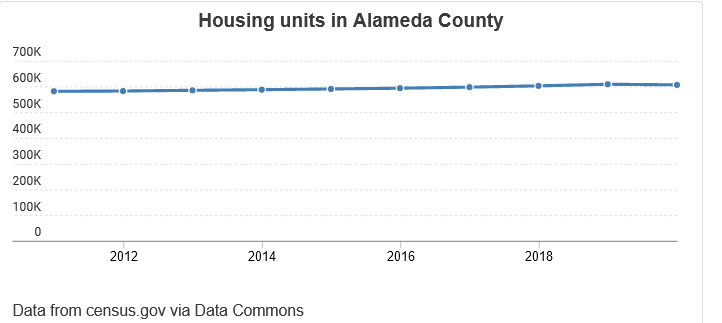

From storm dataset:

    PrD: add monthly columns
    Event counts

In [162]:
n_storm_data = storm_data[['BEGIN_LOCATION', 'BEGIN_DATE', 'BEGIN_TIME', 'EVENT_TYPE', 'DAMAGE_PROPERTY_NUM', 'DAMAGE_CROPS_NUM']].copy()

In [163]:
n_storm_data.head()

BEGIN_LOCATION  BEGIN_DATE  BEGIN_TIME  EVENT_TYPE  DAMAGE_PROPERTY_NUM  \
0                 12/17/1992        1230     Tornado                  250   
1      Livermore  04/25/1994        1150     Tornado                50000   
2        OAKLAND  12/05/1996           0  Heavy Rain              1000000   
3        OAKLAND  12/05/1996         415  Heavy Rain              1000000   
4        HAYWARD  01/11/1998         900  Heavy Rain                    0   

   DAMAGE_CROPS_NUM  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [164]:
n_storm_data['MONTH'] = n_storm_data.BEGIN_DATE.apply(lambda x: x[:2])
n_storm_data['YEAR'] = n_storm_data.BEGIN_DATE.apply(lambda x: x[-4:])
n_storm_data['DAMAGE'] = n_storm_data.DAMAGE_CROPS_NUM + n_storm_data.DAMAGE_PROPERTY_NUM

In [165]:
n_storm_data

BEGIN_LOCATION  BEGIN_DATE  BEGIN_TIME      EVENT_TYPE  \
0                  12/17/1992        1230         Tornado   
1       Livermore  04/25/1994        1150         Tornado   
2         OAKLAND  12/05/1996           0      Heavy Rain   
3         OAKLAND  12/05/1996         415      Heavy Rain   
4         HAYWARD  01/11/1998         900      Heavy Rain   
..            ...         ...         ...             ...   
94     PLEASANTON  03/15/2021        1500            Hail   
95                 06/17/2021        1500            Heat   
96                 07/10/2021        1055  Excessive Heat   
97                 07/11/2021         822        Wildfire   
98                 07/11/2021         950  Excessive Heat   

    DAMAGE_PROPERTY_NUM  DAMAGE_CROPS_NUM MONTH  YEAR   DAMAGE  
0                   250                 0    12  1992      250  
1                 50000                 0    04  1994    50000  
2               1000000                 0    12  1996  1000000  
3               1000000                 0    12  1996  1000000  
4                     0                 0    01  1998        0  
..                  ...               ...   ...   ...      ...  
94                    0                 0    03  2021        0  
95                    0                 0    06  2021        0  
96                    0                 0    07  2021        0  
97                    0                 0    07  2021        0  
98                    0                 0    07  2021        0  

[99 rows x 9 columns]

In [166]:
n_storm_data['EVENT_TYPE'].unique()

array(['Tornado', 'Heavy Rain', 'Hail', 'Heat', 'Frost/Freeze',
       'Winter Weather', 'Thunderstorm Wind', 'Dense Fog',
       'Excessive Heat', 'Wildfire', 'Heavy Snow'], dtype=object)

In [167]:
# n_storm_data.groupby(['YEAR', 'MONTH', 'EVENT_TYPE']).size().reset_index(name='storm_count')

In [168]:
# n_storm_data_count = n_storm_data.groupby(['YEAR', 'MONTH', 'EVENT_TYPE']).size().reset_index(name='storm_count')

In [169]:
n_storm_data_count = n_storm_data.groupby(['YEAR', 'EVENT_TYPE']).size().reset_index(name='storm_count')

In [170]:
n_storm_data_count

YEAR         EVENT_TYPE  storm_count
0   1992            Tornado            1
1   1994            Tornado            1
2   1996         Heavy Rain            2
3   1998         Heavy Rain            1
4   1999               Hail            1
5   2006               Heat            3
6   2007       Frost/Freeze            1
7   2007               Heat            1
8   2008       Frost/Freeze            1
9   2008         Heavy Rain            1
10  2009               Heat            4
11  2009         Heavy Rain            1
12  2009     Winter Weather            1
13  2010         Heavy Rain            1
14  2012         Heavy Rain            1
15  2015         Heavy Rain            1
16  2017               Hail            2
17  2017               Heat            2
18  2017  Thunderstorm Wind            1
19  2018          Dense Fog           10
20  2018               Hail           11
21  2018         Heavy Rain            1
22  2019          Dense Fog            9
23  2019     Excessive Heat            2
24  2019               Hail            2
25  2019               Heat            3
26  2019           Wildfire            9
27  2019     Winter Weather            5
28  2020     Excessive Heat            2
29  2020               Hail            2
30  2020         Heavy Snow            1
31  2020  Thunderstorm Wind            1
32  2020           Wildfire            7
33  2021     Excessive Heat            2
34  2021       Frost/Freeze            2
35  2021               Hail            1
36  2021               Heat            1
37  2021           Wildfire            1

In [171]:
# n_storm_data_count['month_storm'] = n_storm_data_count['MONTH'] + '_' + n_storm_data_count['EVENT_TYPE']

In [172]:
# n_storm_data_count.head()

In [173]:
n_storm_data_count = n_storm_data_count.pivot(index='YEAR', columns='EVENT_TYPE', values=['storm_count'])

In [174]:
n_storm_data_count.fillna(0, inplace=True)

In [175]:
n_storm_data_count

storm_count                                                    \
EVENT_TYPE   Dense Fog Excessive Heat Frost/Freeze  Hail Heat Heavy Rain   
YEAR                                                                       
1992               0.0            0.0          0.0   0.0  0.0        0.0   
1994               0.0            0.0          0.0   0.0  0.0        0.0   
1996               0.0            0.0          0.0   0.0  0.0        2.0   
1998               0.0            0.0          0.0   0.0  0.0        1.0   
1999               0.0            0.0          0.0   1.0  0.0        0.0   
2006               0.0            0.0          0.0   0.0  3.0        0.0   
2007               0.0            0.0          1.0   0.0  1.0        0.0   
2008               0.0            0.0          1.0   0.0  0.0        1.0   
2009               0.0            0.0          0.0   0.0  4.0        1.0   
2010               0.0            0.0          0.0   0.0  0.0        1.0   
2012               0.0            0.0          0.0   0.0  0.0        1.0   
2015               0.0            0.0          0.0   0.0  0.0        1.0   
2017               0.0            0.0          0.0   2.0  2.0        0.0   
2018              10.0            0.0          0.0  11.0  0.0        1.0   
2019               9.0            2.0          0.0   2.0  3.0        0.0   
2020               0.0            2.0          0.0   2.0  0.0        0.0   
2021               0.0            2.0          2.0   1.0  1.0        0.0   

                                                                         
EVENT_TYPE Heavy Snow Thunderstorm Wind Tornado Wildfire Winter Weather  
YEAR                                                                     
1992              0.0               0.0     1.0      0.0            0.0  
1994              0.0               0.0     1.0      0.0            0.0  
1996              0.0               0.0     0.0      0.0            0.0  
1998              0.0               0.0     0.0      0.0            0.0  
1999              0.0               0.0     0.0      0.0            0.0  
2006              0.0               0.0     0.0      0.0            0.0  
2007              0.0               0.0     0.0      0.0            0.0  
2008              0.0               0.0     0.0      0.0            0.0  
2009              0.0               0.0     0.0      0.0            1.0  
2010              0.0               0.0     0.0      0.0            0.0  
2012              0.0               0.0     0.0      0.0            0.0  
2015              0.0               0.0     0.0      0.0            0.0  
2017              0.0               1.0     0.0      0.0            0.0  
2018              0.0               0.0     0.0      0.0            0.0  
2019              0.0               0.0     0.0      9.0            5.0  
2020              1.0               1.0     0.0      7.0            0.0  
2021              0.0               0.0     0.0      1.0            0.0

In [176]:
n_storm_data_damage = n_storm_data.groupby(['YEAR']).sum().DAMAGE.reset_index(name='storm_damage')

/var/folders/x3/2hd_qhx56tq45b4y4z4nl7br0000gr/T/ipykernel_54297/3526279626.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [177]:
n_storm_data_damage

YEAR  storm_damage
0   1992           250
1   1994         50000
2   1996       2000000
3   1998             0
4   1999             0
5   2006             0
6   2007        400000
7   2008         35000
8   2009         80000
9   2010             0
10  2012         10000
11  2015             0
12  2017       5010020
13  2018             0
14  2019         10000
15  2020             0
16  2021             0

In [178]:
n_storm_data_damage.set_index('YEAR', inplace=True)

In [179]:
# n_storm_data_damage = n_storm_data.groupby(['YEAR', 'MONTH']).sum().DAMAGE.reset_index(name='storm_damage')

In [180]:
# n_storm_data_damage.head()

In [181]:
# n_storm_data_damage = n_storm_data_damage.pivot(index='YEAR', columns='MONTH', values=['storm_damage'])

In [182]:
n_filtered_storm_data = pd.concat([n_storm_data_damage, n_storm_data_count], axis=1)

In [183]:
n_filtered_storm_data.index.dtype

dtype('O')

In [184]:
new_dataset.index.dtype

dtype('int64')

In [185]:
n_filtered_storm_data.index = n_filtered_storm_data.index.astype('int64')

In [186]:
complete_data = pd.concat([new_dataset, n_filtered_storm_data], axis=1).fillna(0)

In [187]:
new_dataset.shape

(32, 168)

In [188]:
n_filtered_storm_data.shape

(17, 12)

In [189]:
complete_data.shape

(32, 180)

In [190]:
complete_data.head()

avg_temp_val_1  avg_temp_val_2  avg_temp_val_3  avg_temp_val_4  \
1990            47.7            46.6            53.0            59.2   
1991            47.6            53.6            48.8            54.5   
1992            45.3            53.0            54.7            60.0   
1993            46.1            48.8            55.7            56.5   
1994            48.4            47.5            54.7            56.3   

      avg_temp_val_5  avg_temp_val_6  avg_temp_val_7  avg_temp_val_8  \
1990            60.6            66.4            71.1            71.3   
1991            58.2            63.1            70.1            68.3   
1992            65.8            66.4            71.0            71.6   
1993            61.9            68.2            69.5            70.7   
1994            59.8            66.0            68.0            70.2   

      avg_temp_val_9  avg_temp_val_10  ...  (storm_count, Excessive Heat)  \
1990            68.8             64.0  ...                            0.0   
1991            69.5             65.5  ...                            0.0   
1992            68.9             65.2  ...                            0.0   
1993            67.8             63.3  ...                            0.0   
1994            68.0             61.3  ...                            0.0   

      (storm_count, Frost/Freeze)  (storm_count, Hail)  (storm_count, Heat)  \
1990                          0.0                  0.0                  0.0   
1991                          0.0                  0.0                  0.0   
1992                          0.0                  0.0                  0.0   
1993                          0.0                  0.0                  0.0   
1994                          0.0                  0.0                  0.0   

      (storm_count, Heavy Rain)  (storm_count, Heavy Snow)  \
1990                        0.0                        0.0   
1991                        0.0                        0.0   
1992                        0.0                        0.0   
1993                        0.0                        0.0   
1994                        0.0                        0.0   

      (storm_count, Thunderstorm Wind)  (storm_count, Tornado)  \
1990                               0.0                     0.0   
1991                               0.0                     0.0   
1992                               0.0                     1.0   
1993                               0.0                     0.0   
1994                               0.0                     1.0   

      (storm_count, Wildfire)  (storm_count, Winter Weather)  
1990                      0.0                            0.0  
1991                      0.0                            0.0  
1992                      0.0                            0.0  
1993                      0.0                            0.0  
1994                      0.0                            0.0  

[5 rows x 180 columns]

## Machine Learning Time:

In [191]:
complete_data

avg_temp_val_1  avg_temp_val_2  avg_temp_val_3  avg_temp_val_4  \
1990            47.7            46.6            53.0            59.2   
1991            47.6            53.6            48.8            54.5   
1992            45.3            53.0            54.7            60.0   
1993            46.1            48.8            55.7            56.5   
1994            48.4            47.5            54.7            56.3   
1995            51.0            52.5            51.9            55.0   
1996            49.4            52.9            54.7            58.8   
1997            48.4            51.7            55.9            58.1   
1998            49.6            49.2            53.0            54.8   
1999            47.3            48.2            49.3            54.7   
2000            49.9            51.0            53.5            58.0   
2001            46.4            48.3            55.6            53.2   
2002            46.1            51.1            51.9            56.0   
2003            52.0            49.8            54.5            52.4   
2004            47.2            49.4            58.9            59.2   
2005            46.5            52.0            55.2            55.1   
2006            49.1            51.1            48.4            54.6   
2007            46.0            50.1            56.1            56.9   
2008            46.0            49.6            52.8            55.3   
2009            49.5            49.3            52.4            56.0   
2010            48.4            51.1            52.5            53.2   
2011            48.2            48.0            51.7            54.7   
2012            49.4            50.9            51.2            56.8   
2013            45.8            48.8            55.2            60.0   
2014            53.2            52.5            56.9            58.8   
2015            51.2            55.7            59.1            58.0   
2016            50.0            55.2            55.1            59.1   
2017            46.5            51.0            55.5            56.8   
2018            51.1            51.5            51.9            56.8   
2019            50.8            46.2            51.9            59.3   
2020            48.9            53.9            51.5            57.6   
2021            50.2            51.8            51.9            58.1   

      avg_temp_val_5  avg_temp_val_6  avg_temp_val_7  avg_temp_val_8  \
1990            60.6            66.4            71.1            71.3   
1991            58.2            63.1            70.1            68.3   
1992            65.8            66.4            71.0            71.6   
1993            61.9            68.2            69.5            70.7   
1994            59.8            66.0            68.0            70.2   
1995            58.6            64.9            71.2            71.1   
1996            62.3            67.4            73.0            72.2   
1997            66.4            66.7            70.6            70.8   
1998            56.2            63.5            70.1            72.9   
1999            57.8            64.7            68.0            68.7   
2000            62.1            68.3            67.5            69.9   
2001            67.5            68.9            69.2            69.9   
2002            60.0            66.2            70.4            69.8   
2003            61.1            67.0            72.7            70.7   
2004            61.8            65.9            70.2            71.0   
2005            61.6            64.5            72.7            71.3   
2006            62.8            68.9            74.4            69.0   
2007            61.6            66.3            70.1            70.9   
2008            61.7            67.4            70.5            71.3   
2009            63.2            65.9            69.8            70.8   
2010            57.7            66.3            68.7            67.6   
2011            57.6            64.2         

## Machine Learning Models
### Scale and split data into train and test

In [192]:
x = complete_data
y = electricity_consumption

### Min-max scaling

In [193]:
x.columns = [str(i) for i in x.columns]

In [194]:
complete_data_scaler = MinMaxScaler()
x = complete_data_scaler.fit_transform(x)

### Train-Test split

In [195]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [196]:
complete_data.dtypes

avg_temp_val_1                          float64
avg_temp_val_2                          float64
avg_temp_val_3                          float64
avg_temp_val_4                          float64
avg_temp_val_5                          float64
                                         ...   
('storm_count', 'Heavy Snow')           float64
('storm_count', 'Thunderstorm Wind')    float64
('storm_count', 'Tornado')              float64
('storm_count', 'Wildfire')             float64
('storm_count', 'Winter Weather')       float64
Length: 180, dtype: object

### Linear Regression

In [197]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [198]:
lr_model.score(x_test, y_test)
#-1.0877643516992328

-0.8127128419760992

In [199]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [200]:
ridge_model = Ridge(alpha=1e5)
ridge_model.fit(x_train, y_train)
ridge_model.score(x_test, y_test)

-0.028146759777815555

In [201]:
lasso_model = Lasso(alpha=1e5)
lasso_model.fit(x_train, y_train)
lasso_model.score(x_test, y_test)

-0.02812251206346894

### SVM

In [202]:
svr_model = SVR()
svr_model.fit(x_train, y_train)
svr_model.score(x_test, y_test)
#-0.04973899231804113

-0.04191337076461421

In [203]:
svr_model = SVR(C=0.3, gamma='auto', kernel='rbf')
svr_model.fit(x_train, y_train)
svr_model.score(x_test, y_test)
#-0.04973899231804113

-0.04202579898354064

### Decision Tree

In [204]:
dtr_model = DecisionTreeRegressor(random_state=42)
dtr_model.fit(x_train, y_train)
dtr_model.score(x_test, y_test)
#-1.5198989146989983

-2.0162470776735857

In [205]:
dtr_model = DecisionTreeRegressor(max_depth=6, min_samples_split=4, min_samples_leaf=7, random_state=42)
dtr_model.fit(x_train, y_train)
dtr_model.score(x_test, y_test)
#-1.5198989146989983

-0.22152605864070152

## Post-PCA

In [206]:
x.shape

(32, 180)

In [207]:
pca = PCA()
pca.fit(x)
np.cumsum(pca.explained_variance_ratio_)

array([0.19644955, 0.31390518, 0.42296773, 0.4952688 , 0.55727851,
       0.6166006 , 0.66983966, 0.71243405, 0.75003864, 0.78447568,
       0.81617111, 0.83988546, 0.86236233, 0.8823059 , 0.89941205,
       0.91303308, 0.92594004, 0.93573114, 0.94498866, 0.95393084,
       0.96180461, 0.96898858, 0.97485025, 0.98033516, 0.98492583,
       0.9891084 , 0.99230676, 0.99483139, 0.99704998, 0.99891506,
       1.        , 1.        ])

In [208]:
x_new = pca.transform(x)

### Train-Test split

In [209]:
x_new_train, x_new_test, y_train, y_test = train_test_split(x_new, y, test_size=0.33, random_state=42)

### Linear Regression

In [210]:
lr_model = LinearRegression()
lr_model.fit(x_new_train, y_train)

LinearRegression()

In [211]:
lr_model.score(x_new_test, y_test)
#-0.7591519131428217

-0.8565018730750882

### SVM

In [212]:
svr_model = SVR()
svr_model.fit(x_new_train, y_train)
svr_model.score(x_new_test, y_test)

-0.04207374590487434

In [213]:
svr2_model = SVR(C=1e-5)
svr2_model.fit(x_new_train, y_train)
svr2_model.score(x_new_test, y_test)

-0.042050161985839996

In [214]:
mean_squared_error(svr2_model.predict(x_new_test), y_test)

37689.45588736106

### Decision Tree

In [215]:
dtr_model = DecisionTreeRegressor(max_depth=4, min_samples_split=2, min_samples_leaf=5, random_state=42)
dtr_model.fit(x_new_train, y_train)
dtr_model.score(x_new_test, y_test)

-1.0209811745696933

In [216]:
from sklearn.tree import plot_tree

[Text(0.6, 0.8333333333333334, 'x[6] <= 0.442\nsquared_error = 48999.854\nsamples = 21\nvalue = 2866.23'),
 Text(0.4, 0.5, 'x[4] <= -0.433\nsquared_error = 20115.189\nsamples = 14\nvalue = 2979.748'),
 Text(0.2, 0.16666666666666666, 'squared_error = 13847.945\nsamples = 5\nvalue = 3090.241'),
 Text(0.6, 0.16666666666666666, 'squared_error = 13046.152\nsamples = 9\nvalue = 2918.362'),
 Text(0.8, 0.5, 'squared_error = 29452.071\nsamples = 7\nvalue = 2639.196')]

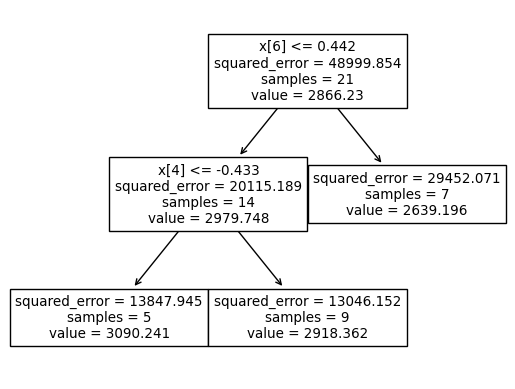

In [217]:
plot_tree(dtr_model)

### Random Forest

In [218]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42, min_samples_split=3, max_depth=3, n_jobs=-1, n_estimators=200)
rf_model.fit(x_new_train, y_train)
rf_model.score(x_new_test, y_test)

-0.32766391991408916

## Cross Validation
Since our dataset is very small

In [219]:
x.shape

(32, 180)

In [220]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RandomForestRegressor(n_estimators=200 ,min_samples_split=3,
                                               random_state=42, max_depth=3),
                         X = x , y = y , cv = 5)

In [221]:
scores

array([-16.44120954,  -2.37092431,  -3.36517755,  -4.49145389,
        -2.52858035])

It seems that we have overfit (See the last entry)

In [222]:
np.mean(scores)

-5.839469128145551

### Leave One Out

Since our data is very small, it makes sense to use Leave One Out cross-validation to ensure that we consider each data point.

In [223]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
predictions = []
for loo_train_indices, loo_test_indices in loo.split(x_new):
    loo_x_train, loo_x_test = x_new[loo_train_indices], x_new[loo_test_indices]
    loo_y_train, loo_y_test = y.values[loo_train_indices], y.values[loo_test_indices]
    rf_loo_model = RandomForestRegressor(n_estimators=2000, max_depth=3,
                                         min_samples_split=3, min_samples_leaf=5, bootstrap=True,
                                         random_state=42, n_jobs=-1)
    rf_loo_model.fit(loo_x_train, loo_y_train)
    predictions.append(mean_squared_error(rf_loo_model.predict(loo_x_test), loo_y_test))

In [224]:
predictions

[123150.43803796497,
 77989.18312913403,
 137175.4939202302,
 104952.91988325697,
 22101.526106288376,
 99114.17488968915,
 81063.17294819695,
 48709.99954882206,
 1196.2700768114407,
 369.23486526029063,
 2914.2102711558246,
 48496.19015366715,
 20562.704422539893,
 12224.399392780835,
 2855.8213575592413,
 85989.952014825,
 25898.206450023103,
 26310.80217288137,
 24493.07398057257,
 3014.3966787495874,
 12190.67597056662,
 45976.04896650844,
 11745.54106693606,
 3560.2317441274745,
 2465.7823631767315,
 13935.236318908406,
 6817.663683508463,
 15850.063833013532,
 2064.6764059081524,
 9233.32753909629,
 231710.51990474362,
 167631.8175220418]

In [225]:
np.mean(predictions)

45992.61736309202

In [226]:
predictions = []
for loo_train_indices, loo_test_indices in loo.split(x_new):
    loo_x_train, loo_x_test = x_new[loo_train_indices], x_new[loo_test_indices]
    loo_y_train, loo_y_test = y.values[loo_train_indices], y.values[loo_test_indices]
    svr_loo_model = SVR(C=1e-5)
    svr_loo_model.fit(loo_x_train, loo_y_train)
    predictions.append(mean_squared_error(svr_loo_model.predict(loo_x_test), loo_y_test))
np.mean(predictions)

47804.452201084234

In [227]:
predictions

[183057.6480897789,
 168845.40372448534,
 212629.72722465638,
 157520.63394676876,
 22967.90776368421,
 142627.09739027757,
 96602.36526215133,
 63143.44173897631,
 18167.48433186945,
 1249.6685924129,
 27.006845025530414,
 32726.26598937124,
 13107.285939842524,
 262.45897525265116,
 799.7070375306375,
 10889.743655180622,
 38955.26649884925,
 2599.760756297478,
 5700.659626503383,
 9183.299354277739,
 10151.823911214435,
 10800.830997747582,
 6203.5283359760115,
 4264.7771678023255,
 1015.3543148880185,
 819.334015050722,
 27.006845609244998,
 5495.373574045497,
 753.3646654210418,
 8925.104726017596,
 150192.19654458069,
 150030.9425931502]

In [228]:
predictions = []
for loo_train_indices, loo_test_indices in loo.split(x):
    loo_x_train, loo_x_test = x[loo_train_indices], x[loo_test_indices]
    loo_y_train, loo_y_test = y.values[loo_train_indices], y.values[loo_test_indices]
    svr_loo_model = SVR(C=1e-5)
    svr_loo_model.fit(loo_x_train, loo_y_train)
    predictions.append(mean_squared_error(svr_loo_model.predict(loo_x_test), loo_y_test))
np.mean(predictions)

47804.452481243825

In [229]:
from xgboost import XGBRegressor

In [230]:
predictions = []
for loo_train_indices, loo_test_indices in loo.split(x):
    loo_x_train, loo_x_test = x[loo_train_indices], x[loo_test_indices]
    loo_y_train, loo_y_test = y.values[loo_train_indices], y.values[loo_test_indices]
    XGB_loo_model = XGBRegressor()
    XGB_loo_model.fit(loo_x_train, loo_y_train)
    predictions.append(mean_squared_error(XGB_loo_model.predict(loo_x_test), loo_y_test))
np.mean(predictions)

43357.86160970882

In [231]:
predictions

[129766.34168318845,
 145131.2289959621,
 155017.47177360798,
 108174.96020059436,
 17029.07975319799,
 10546.738598069383,
 7890.5337104478385,
 18878.956048840228,
 11759.03638574312,
 18964.23534524466,
 27239.92665633705,
 17672.871925024465,
 33451.53847002961,
 2.6162862334758348,
 1101.521680481167,
 26498.676627238878,
 27861.38942608549,
 10450.288573998621,
 6328.725557029758,
 50667.534310097064,
 2292.7585391242737,
 4771.831233336728,
 5753.7291488585,
 107967.99407948882,
 84583.09641991614,
 9.676842262081793,
 9969.205912218085,
 44319.79379446894,
 119.80036168264586,
 40406.633014054445,
 149663.78341408537,
 113159.5967437347]

In [232]:
XGB_model = XGBRegressor()
XGB_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [233]:
XGB_model.feature_importances_

array([1.0596251e-03, 1.0241880e-02, 4.9473002e-04, 5.9818108e-06,
       0.0000000e+00, 1.5212617e-09, 3.9005730e-08, 3.4741771e-03,
       9.0784197e-06, 1.2154803e-03, 2.5613060e-11, 5.7006042e-02,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       8.5483245e-11, 0.0000000e+00, 5.5783043e-12, 0.0000000e+00,
       1.3159271e-04, 4.9701921e-04, 8.6236832e-05, 4.0516839e-04,
       2.0064113e-05, 2.0921063e-09, 0.0000000e+00, 7.0338490e-07,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       8.9079975e-08, 0.0000000e+00, 5.7922520e-02, 7.0648922e-09,
       0.0000000e+00, 1.2325555e-06, 1.7033709e-03, 1.7085113e-04,
       0.0000000e+00, 2.5274038e-01, 6.0256561e-06, 0.0000000e

In [234]:
sorted_importance = sorted(
    [_ for _ in zip(complete_data.columns, XGB_model.feature_importances_)],
    key=lambda x: x[1], reverse = True)
plot_x = [_[0] for _ in sorted_importance]
plot_y = [_[1] for _ in sorted_importance]

<BarContainer object of 180 artists>

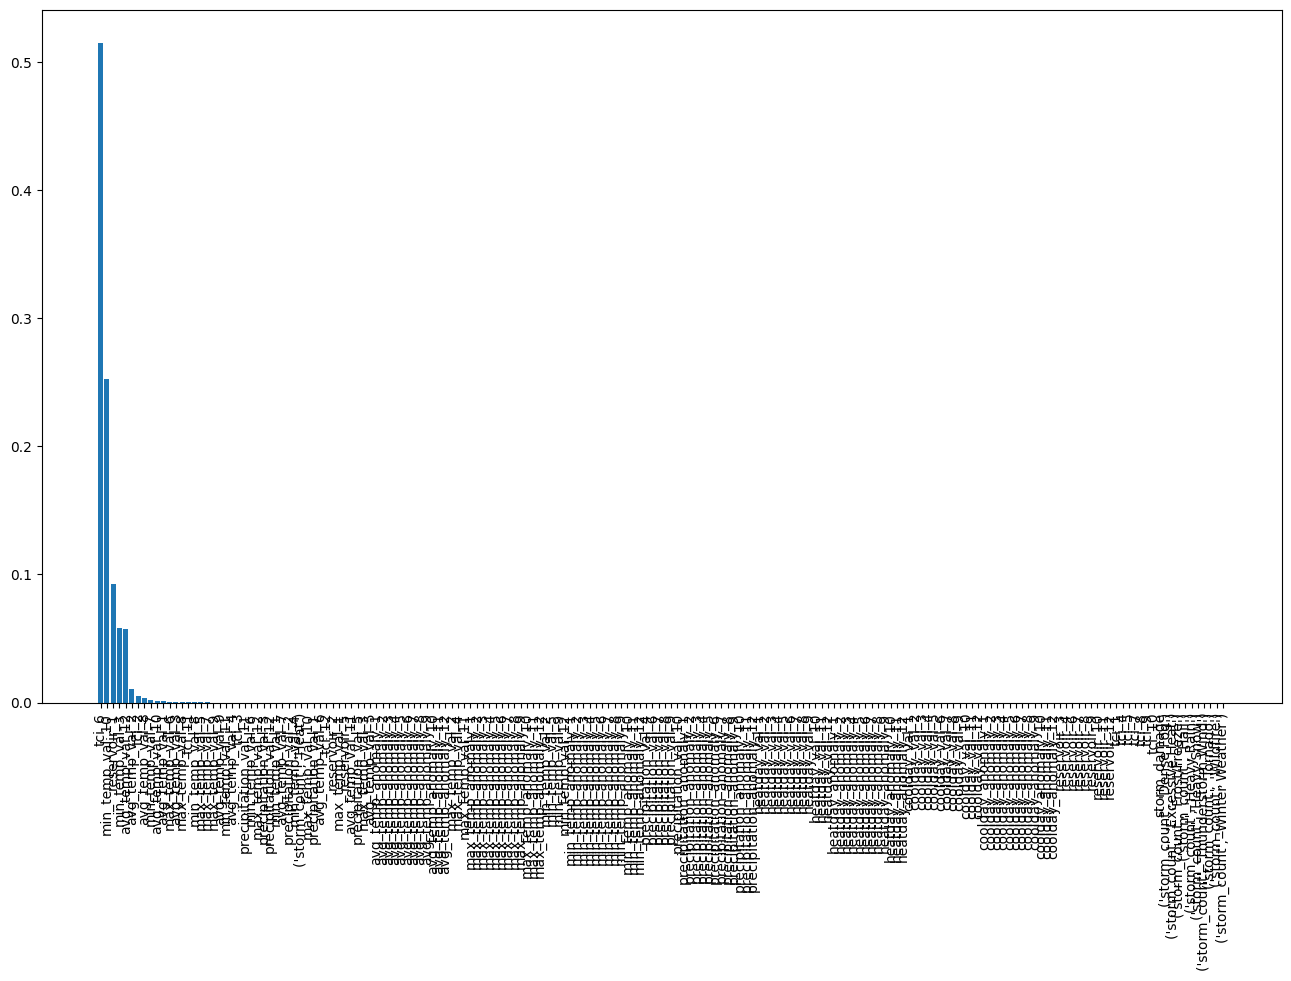

In [235]:
plt.figure(figsize=(16, 9))
plt.xticks(rotation=90)
plt.bar(plot_x, plot_y)

<BarContainer object of 180 artists>

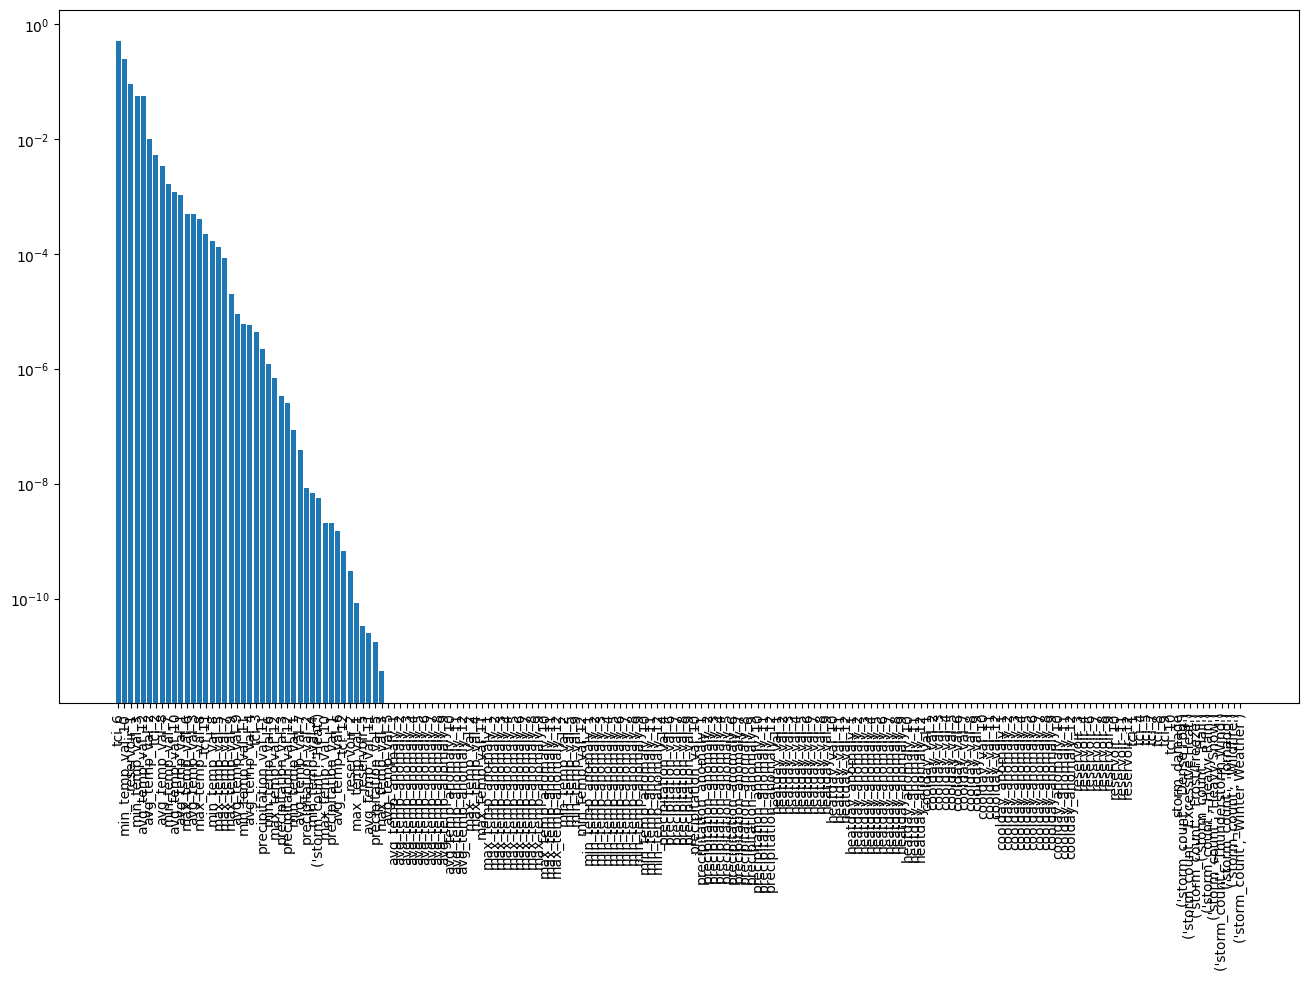

In [236]:
plt.figure(figsize=(16, 9))
plt.xticks(rotation=90)
plt.bar(plot_x, plot_y, log=True)

In [237]:
sorted_importance[:10]

[('tci_6', 0.5150252),
 ('min_temp_val_10', 0.25274038),
 ('reservoir_1', 0.09211645),
 ('min_temp_val_3', 0.05792252),
 ('avg_temp_val_12', 0.057006042),
 ('avg_temp_val_2', 0.01024188),
 ('tci_2', 0.005430093),
 ('avg_temp_val_8', 0.003474177),
 ('min_temp_val_7', 0.001703371),
 ('avg_temp_val_10', 0.0012154803)]

In [248]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

In [363]:
model = Sequential([
    Dense(128, activation="relu", input_shape=(180,)),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(4, activation="relu"),
    Dense(1, activation="sigmoid")
])
model.compile(loss="mse",
              optimizer="adam",
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
# optimizer=tf.keras.optimizers.Adam(0.001)

In [364]:
predictions = []
for loo_train_indices, loo_test_indices in loo.split(x):
    loo_x_train, loo_x_test = x[loo_train_indices], x[loo_test_indices]
#     loo_y_train, loo_y_test = y.values[loo_train_indices]/y.max(), y.values[loo_test_indices]/y.max()
    loo_y_train, loo_y_test = y.values[loo_train_indices]/y.max(), y.values[loo_test_indices]/y.max()
    model.fit(loo_x_train, loo_y_train, epochs=3)
    predictions.append(mean_squared_error(model.predict(loo_x_test), loo_y_test))
np.mean(predictions)

Epoch 1/3
1/1 [==============================] - 0s 189ms/step - loss: 0.1623 - root_mean_squared_error: 0.4028
Epoch 2/3
1/1 [==============================] - 0s 2ms/step - loss: 0.1500 - root_mean_squared_error: 0.3873
Epoch 3/3
1/1 [==============================] - 0s 29ms/step
Epoch 1/3
1/1 [==============================] - 0s 2ms/step - loss: 0.1359 - root_mean_squared_error: 0.3686
Epoch 2/3
1/1 [==============================] - 0s 3ms/step - loss: 0.1297 - root_mean_squared_error: 0.3601
Epoch 3/3
1/1 [==============================] - 0s 7ms/step
Epoch 1/3
1/1 [==============================] - 0s 2ms/step - loss: 0.1158 - root_mean_squared_error: 0.3403
Epoch 2/3
1/1 [==============================] - 0s 4ms/step - loss: 0.1074 - root_mean_squared_error: 0.3277
Epoch 3/3
1/1 [==============================] - 0s 7ms/step
Epoch 1/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0883 - root_mean_squared_error: 0.2971
Epoch 2/3
1/1 [=============================

1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - root_mean_squared_error: 0.0594
Epoch 3/3
1/1 [==============================] - 0s 7ms/step
Epoch 1/3
1/1 [==============================] - 0s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0591
Epoch 2/3
1/1 [==============================] - 0s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0589
Epoch 3/3
1/1 [==============================] - 0s 7ms/step
Epoch 1/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593
Epoch 2/3
1/1 [==============================] - 0s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0592
Epoch 3/3
1/1 [==============================] - 0s 7ms/step
Epoch 1/3
1/1 [==============================] - 0s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595
Epoch 2/3
1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - root_mean_squared_error: 0.0592
Epoch 3/3
1/1 [==============================] - 0s 8ms/s

0.009806933532621983

In [365]:
from sklearn.metrics import r2_score

In [366]:
r2_score(y_test/y.max(), model.predict(x_test))

1/1 [==============================] - 0s 11ms/step


0.48907131295497464

In [367]:
y_test

2019    3015.393947
2005    3025.275108
2014    2894.253363
2007    2971.909026
1998    2791.331173
1999    2890.767335
2020    3308.467553
2015    2897.493974
2002    2811.630947
1990    2498.265626
1994    2774.566317
Name: 0, dtype: float64

In [368]:
model.predict(x_test)*y.max()

1/1 [==============================] - 0s 11ms/step


array([[2959.2644],
       [2834.8792],
       [2963.8113],
       [2791.7034],
       [2857.3013],
       [2829.2854],
       [3040.6125],
       [2872.7139],
       [2810.3564],
       [2697.0227],
       [2693.5535]], dtype=float32)

1/1 [==============================] - 0s 10ms/step


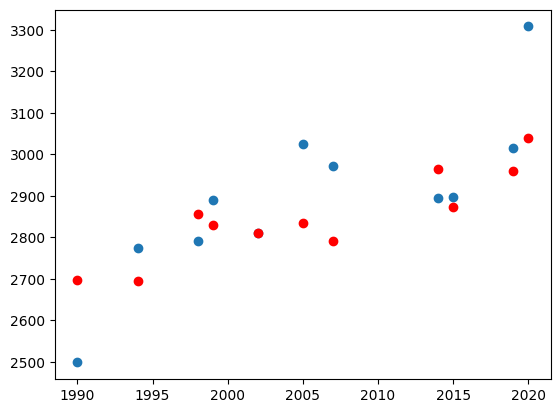

In [369]:
plt.scatter(y_test.index, y_test)
plt.scatter(y_test.index, model.predict(x_test)*y.max(), color='r')

In [370]:
y

1990    2498.265626
1991    2515.209970
1992    2465.000074
1993    2529.229286
1994    2774.566317
1995    2548.457958
1996    2615.308775
1997    2674.834394
1998    2791.331173
1999    2890.767335
2000    2926.117980
2001    2745.213966
2002    2811.630947
2003    2937.121764
2004    2897.838896
2005    3025.275108
2006    3118.292069
2007    2971.909026
2008    2996.423893
2009    3016.750714
2010    3021.677436
2011    3024.848218
2012    2999.683662
2013    2986.226437
2014    2894.253363
2015    2897.493974
2016    2920.921179
2017    2995.051965
2018    2948.368675
2019    3015.393947
2020    3308.467553
2021    3308.259460
Name: 0, dtype: float64

### Feature Importance

In [371]:
import shap
import tensorflow.keras

In [372]:
explainer = shap.Explainer(model.predict, x_test)

In [373]:
shap_values = explainer(x_test)

54/54 [==============================] - 0s 330us/step


In [374]:
shap_values

.values =
array([[ 9.69930129e-04, -1.39877742e-03, -2.27584080e-04, ...,
         7.35794956e-04,  6.57983260e-03,  5.15144792e-03],
       [-1.04156949e-03,  6.55225732e-04,  1.79160725e-04, ...,
         7.32402910e-04, -1.20356950e-03, -5.50131906e-04],
       [ 2.13855234e-03,  7.92679462e-04,  4.56869602e-04, ...,
         6.77986579e-04, -1.03577701e-03, -5.03987074e-04],
       ...,
       [-1.33275444e-03,  3.03604386e-04, -2.61285088e-04, ...,
         8.92379067e-04, -1.20188431e-03, -5.54889441e-04],
       [-5.60186126e-04, -1.49033828e-03, -1.18848952e-04, ...,
         7.64974139e-04, -1.26167590e-03, -6.30538572e-04],
       [-1.34749846e-04, -9.94880091e-04,  8.87513161e-05, ...,
        -7.04688376e-03, -1.38910792e-03, -5.55536964e-04]])

.base_values =
array([[0.86143986],
       [0.86143986],
       [0.86143986],
       [0.86143986],
       [0.86143986],
       [0.86143986],
       [0.86143986],
       [0.86143986],
       [0.86143986],
       [0.86143986],
       

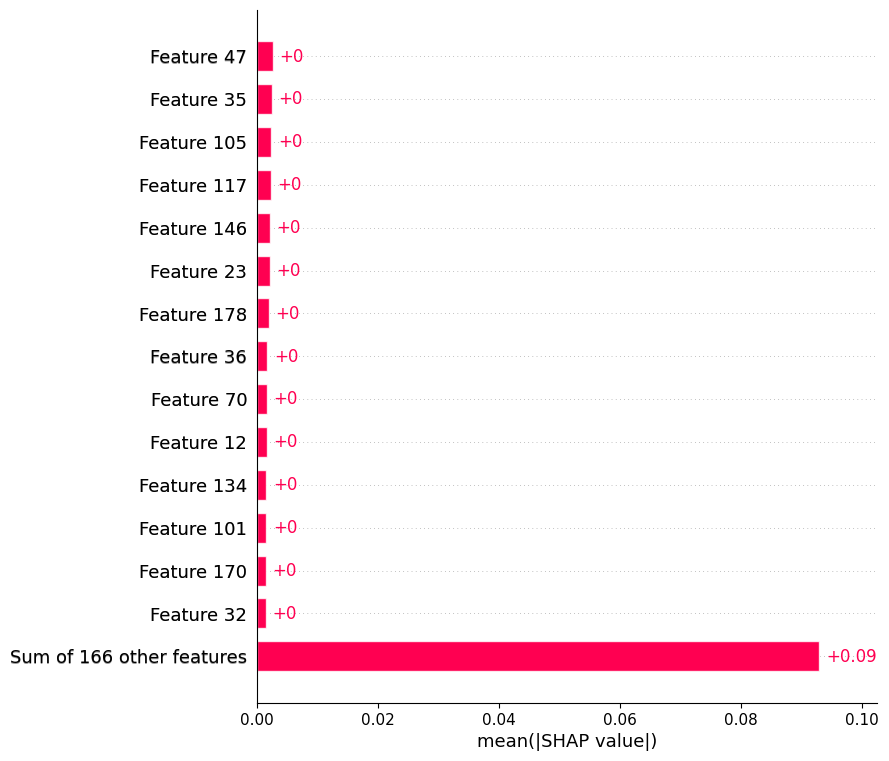

In [375]:
shap.plots.bar(shap_values, max_display=15)

In [376]:
[complete_data.columns[i] for i in [47, 35, 105, 117, 146, 23, 178, 36, 70, 12,
                                    134, 101, 170, 32]]

['max_temp_anomaly_12',
 'max_temp_val_12',
 'heatday_val_10',
 'heatday_anomaly_10',
 'reservoir_3',
 'avg_temp_anomaly_12',
 "('storm_count', 'Wildfire')",
 'max_temp_anomaly_1',
 'min_temp_anomaly_11',
 'avg_temp_anomaly_1',
 'coolday_anomaly_3',
 'heatday_val_6',
 "('storm_count', 'Excessive Heat')",
 'max_temp_val_9']

In [377]:
import pickle

In [405]:
model.save('nn_model.h5')

In [379]:
x.shape

(32, 180)

### Default values for the ML API

In [381]:
tmp = complete_data[['max_temp_anomaly_12',
 'max_temp_val_12',
 'heatday_val_10',
 'heatday_anomaly_10',
 'reservoir_3',
 'avg_temp_anomaly_12',
 "('storm_count', 'Wildfire')",
 'max_temp_anomaly_1',
 'min_temp_anomaly_11',
 'avg_temp_anomaly_1',
 'coolday_anomaly_3',
 'heatday_val_6',
 "('storm_count', 'Excessive Heat')",
 'max_temp_val_9']]

In [382]:
tmp.min()

max_temp_anomaly_12                      -3.2
max_temp_val_12                          52.0
heatday_val_10                           10.0
heatday_anomaly_10                     -119.0
reservoir_3                          128532.0
avg_temp_anomaly_12                      -4.4
('storm_count', 'Wildfire')               0.0
max_temp_anomaly_1                       -1.8
min_temp_anomaly_11                      -3.8
avg_temp_anomaly_1                       -1.1
coolday_anomaly_3                         0.0
heatday_val_6                            14.0
('storm_count', 'Excessive Heat')         0.0
max_temp_val_9                           77.4
dtype: float64

In [383]:
tmp.max()

max_temp_anomaly_12                       4.7
max_temp_val_12                          59.9
heatday_val_10                          163.0
heatday_anomaly_10                       34.0
reservoir_3                          239957.0
avg_temp_anomaly_12                       5.6
('storm_count', 'Wildfire')               9.0
max_temp_anomaly_1                       10.1
min_temp_anomaly_11                       5.0
avg_temp_anomaly_1                        6.8
coolday_anomaly_3                        14.0
heatday_val_6                            92.0
('storm_count', 'Excessive Heat')         2.0
max_temp_val_9                           85.6
dtype: float64

In [384]:
tmp.loc[2021]

max_temp_anomaly_12                      -1.2
max_temp_val_12                          54.0
heatday_val_10                          134.0
heatday_anomaly_10                        5.0
reservoir_3                          168223.0
avg_temp_anomaly_12                       0.0
('storm_count', 'Wildfire')               1.0
max_temp_anomaly_1                        4.7
min_temp_anomaly_11                       5.0
avg_temp_anomaly_1                        3.8
coolday_anomaly_3                         0.0
heatday_val_6                            18.0
('storm_count', 'Excessive Heat')         2.0
max_temp_val_9                           83.3
Name: 2021, dtype: float64

In [391]:
complete_data.loc[2021].values

array([ 5.02000000e+01,  5.18000000e+01,  5.19000000e+01,  5.81000000e+01,
        6.31000000e+01,  6.88000000e+01,  7.26000000e+01,  7.24000000e+01,
        7.04000000e+01,  6.11000000e+01,  5.67000000e+01,  4.71000000e+01,
        3.80000000e+00,  2.30000000e+00,  0.00000000e+00,  2.90000000e+00,
        3.30000000e+00,  3.80000000e+00,  3.50000000e+00,  3.50000000e+00,
        3.20000000e+00, -4.00000000e-01,  3.60000000e+00,  0.00000000e+00,
        5.91000000e+01,  6.15000000e+01,  6.27000000e+01,  7.03000000e+01,
        7.60000000e+01,  8.15000000e+01,  8.55000000e+01,  8.52000000e+01,
        8.33000000e+01,  7.13000000e+01,  6.53000000e+01,  5.40000000e+01,
        4.70000000e+00,  3.50000000e+00,  1.30000000e+00,  4.40000000e+00,
        4.70000000e+00,  4.00000000e+00,  3.20000000e+00,  3.50000000e+00,
        3.30000000e+00, -1.90000000e+00,  2.40000000e+00, -1.20000000e+00,
        4.13000000e+01,  4.20000000e+01,  4.10000000e+01,  4.59000000e+01,
        5.03000000e+01,  

In [392]:
with open('complete_data_scaler.pkl', 'wb') as f:
    pickle.dump(complete_data_scaler, f)

In [394]:
with open('complete_data_2021.pkl', 'wb') as f:
    pickle.dump(complete_data.loc[2021], f)

In [395]:
important_features = [
    'max_temp_anomaly_12',
    'max_temp_val_12',
    'heatday_val_10',
    'heatday_anomaly_10',
    'reservoir_3',
    'avg_temp_anomaly_12',
    "('storm_count', 'Wildfire')",
    'max_temp_anomaly_1',
    'min_temp_anomaly_11',
    'avg_temp_anomaly_1',
    'coolday_anomaly_3',
    'heatday_val_6',
    "('storm_count', 'Excessive Heat')",
    'max_temp_val_9'
]

In [396]:
with open('complete_data_2021.pkl', 'wb') as f:
    pickle.dump(complete_data.loc[2021], f)

In [399]:
with open('important_features.pkl', 'wb') as f:
    pickle.dump(important_features, f)